In [1]:
!pip install statsmodels
# test


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
!pip install pandas openpyxl


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [3]:
!pip install geopandas


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [4]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib
import seaborn
import matplotlib.pyplot as plt
from scipy.stats import iqr
from scipy.stats import median_test


## Import population info from census

In [5]:
#import Pop_County
df_census2020 = pd.read_csv('DECENNIALPL2020.P1-2024-11-10T174624.csv')
df_population_bycounty = df_census2020.head(1)
df_population_bycounty.columns = df_population_bycounty.columns.str.replace(' County, California', '', regex=False)
county_names = df_population_bycounty.columns[1:]
populations = df_population_bycounty.iloc[0, 1:].replace(',', '', regex=True).astype(int)
df_population_bycounty = pd.DataFrame({
    'County': county_names,
    'Population': populations
}).reset_index(drop=True)
df_population_bycounty = df_population_bycounty.rename(columns={'County': 'CountyName'})
print(len(df_population_bycounty))
df_population_bycounty.head()
# county_names


58


,CountyName,Population
0,Alameda,1682353
1,Alpine,1204
2,Amador,40474
3,Butte,211632
4,Calaveras,45292


## Import hospital data

In [6]:
# import hospital data

# df_hospital = pd.read_csv('ed-volume-and-capacity-2021.csv', encoding = "ISO-8859-1", index_col=[0])
# df_hospital = df_hospital[df_hospital["Category"] == "Asthma"]
# df_hospital_bycounty = df_hospital.groupby('CountyName')['EDDXCount'].sum().reset_index()
# df_hospital_bycounty.head()

df_hospital = pd.read_csv('asthma-emergency-department-visit-rates-by-county-2015_2022.csv', encoding = "ISO-8859-1")
df_hospital_bycounty = df_hospital[df_hospital["STRATA NAME"] == "All ages"]
df_hospital_bycounty = df_hospital_bycounty[df_hospital_bycounty["YEAR"] <= 2019]
df_hospital_bycounty = df_hospital_bycounty.rename(columns={'COUNTY': 'CountyName'})
df_hospital_bycounty = df_hospital_bycounty[["CountyName", "YEAR", "AGE-ADJUSTED ED VISIT RATE"]]
df_hospital_bycounty = df_hospital_bycounty[df_hospital_bycounty["CountyName"] != "California"]
print(len(df_hospital_bycounty))
df_hospital_bycounty.head()

290


,CountyName,YEAR,AGE-ADJUSTED ED VISIT RATE
1,Alameda,2015,64.3
2,Alpine,2015,0.0
3,Amador,2015,58.4
4,Butte,2015,50.2
5,Calaveras,2015,48.0


In [7]:
df_hospital_pop_bycounty = pd.merge(df_population_bycounty, df_hospital_bycounty, on='CountyName', how='inner')
df_hospital_pop_bycounty["AGE-ADJUSTED ED VISIT RATE"] = df_hospital_pop_bycounty["AGE-ADJUSTED ED VISIT RATE"].replace({',': ''}, regex=True)
df_hospital_pop_bycounty["AGE-ADJUSTED ED VISIT RATE"] = pd.to_numeric(df_hospital_pop_bycounty["AGE-ADJUSTED ED VISIT RATE"])

df_hospital_pop_bycounty.rename(columns={'AGE-ADJUSTED ED VISIT RATE': 'VisitRate'}, inplace=True)

df_hospital_pop_bycounty = df_hospital_pop_bycounty.dropna()

df_hospital_pop_bycounty['VisitRate'] = (
        df_hospital_pop_bycounty['VisitRate'] - df_hospital_pop_bycounty['VisitRate'].min()
    ) / (df_hospital_pop_bycounty['VisitRate'].max() - df_hospital_pop_bycounty['VisitRate'].min())

print(len(df_hospital_pop_bycounty))
df_hospital_pop_bycounty.head(n=6)

283


,CountyName,Population,YEAR,VisitRate
0,Alameda,1682353,2015,0.588289
1,Alameda,1682353,2016,0.528820
2,Alameda,1682353,2017,0.515096
3,Alameda,1682353,2018,0.444648
4,Alameda,1682353,2019,0.419030
5,Alpine,1204,2015,0.000000


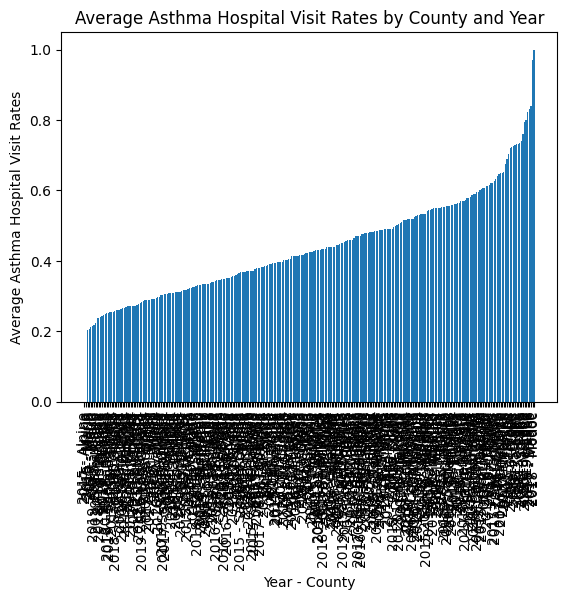

In [8]:
df_hospital_pop_bycounty['YearCounty'] = df_hospital_pop_bycounty['YEAR'].astype(str) + ' - ' + df_hospital_pop_bycounty['CountyName']
df_hospital_pop_bycounty_sorted = df_hospital_pop_bycounty.sort_values(by='VisitRate', ascending=True)
plt.bar(df_hospital_pop_bycounty_sorted['YearCounty'], df_hospital_pop_bycounty_sorted['VisitRate'])
plt.xticks(rotation=90)
plt.xlabel('Year - County')
plt.ylabel('Average Asthma Hospital Visit Rates')
plt.title('Average Asthma Hospital Visit Rates by County and Year')
plt.show()

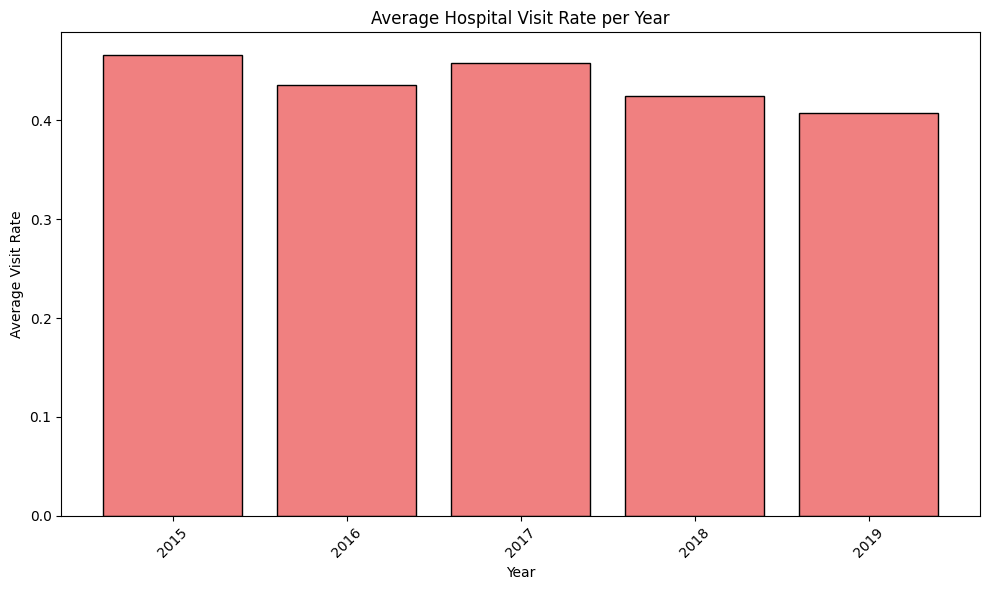

In [9]:
# Calculate the average VisitRate per year
average_visits_per_year = df_hospital_pop_bycounty.groupby('YEAR')['VisitRate'].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(average_visits_per_year.index, average_visits_per_year.values, color='lightcoral', edgecolor='black')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Average Visit Rate')
plt.title('Average Hospital Visit Rate per Year')
plt.xticks(average_visits_per_year.index, rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

## Get AQI Data

In [10]:
# Function to count number of days with aqi at or worse than 100
def make_aqi_df(csv_name, year):
    df_air = pd.read_csv(csv_name, encoding = "ISO-8859-1", index_col=[0])
    df_air = df_air.groupby('County')['Daily AQI Value'].apply(lambda x: (x >= 100).sum()).reset_index()
    df_air = df_air.rename(columns={'Daily AQI Value': 'Weighted AQI Days'})
    df_air['Year'] = year
    return df_air[['County', 'Year', 'Weighted AQI Days']]

In [11]:
# Function to calculate weighted sum of days with bad aqi
# 0-50: weight 0, 51-100: weight 1, 101-150: weight 2, 151-200 weight 3, 201-300 weight 4, >300: weight 5
def calc_weighted_sum(df):
        class_5 = (df['Daily AQI Value'] > 300).sum()
        class_4 = ((df['Daily AQI Value'] > 200) & (df['Daily AQI Value'] <= 300)).sum()
        class_3 = ((df['Daily AQI Value'] > 150) & (df['Daily AQI Value'] <= 200)).sum()
        class_2 = ((df['Daily AQI Value'] > 100) & (df['Daily AQI Value'] <= 150)).sum()
        class_1 = ((df['Daily AQI Value'] > 50) & (df['Daily AQI Value'] <= 100)).sum()

        weighted_sum = 5 * class_5 + 4 * class_4 + 3 * class_3 + 2 * class_2 + class_1
        return weighted_sum

In [12]:
# Function to make df with weighted aqi days from single year csv

def make_weighted_aqi_df(csv_name, year):
    df_air_preprocess = pd.read_csv(csv_name, encoding="ISO-8859-1", index_col=[0])
    number_of_sensors = len(df_air_preprocess['Site ID'].unique())
    num_missing_data = (number_of_sensors * 365 ) - len(df_air_preprocess)
    print("Missing ", num_missing_data, " of expected ", number_of_sensors * 365, "data points in year ", year)
    df_air_preprocess = df_air_preprocess[['County', 'Daily AQI Value', 'Site ID']]
    counties = df_air_preprocess['County'].unique()

    # count instances of different aqi values
    counts_df = pd.DataFrame(columns=['County', 'Weighted AQI Days'])
    county_sum = 0
    for county in counties:
        county_df = df_air_preprocess[df_air_preprocess['County'] == county]

        for sensor in county_df['Site ID'].unique():
            sensor_df = county_df[county_df['Site ID'] == sensor]
            sensor_sum = calc_weighted_sum(sensor_df)
            county_sum += sensor_sum / len(sensor_df)

        county_sum = county_sum / len(county_df['Site ID'].unique())

        new_df_row = pd.DataFrame([[county, county_sum]], columns=['County', 'Weighted AQI Days'])
        counts_df = pd.concat([counts_df, new_df_row])

    counts_df['Year'] = year
    return counts_df.reset_index()

In [13]:
# Get all CA counties
df_air_raw = pd.read_csv('air_quality_2019.csv', encoding="ISO-8859-1", index_col=[0])
CA_counties = df_air_raw['County'].unique()
print(CA_counties)

['Alameda' 'Butte' 'Calaveras' 'Colusa' 'Contra Costa' 'Del Norte'
 'El Dorado' 'Fresno' 'Glenn' 'Humboldt' 'Imperial' 'Inyo' 'Kern' 'Kings'
 'Lake' 'Los Angeles' 'Madera' 'Marin' 'Mariposa' 'Mendocino' 'Merced'
 'Mono' 'Monterey' 'Napa' 'Nevada' 'Orange' 'Placer' 'Plumas' 'Riverside'
 'Sacramento' 'San Benito' 'San Bernardino' 'San Diego' 'San Francisco'
 'San Joaquin' 'San Luis Obispo' 'San Mateo' 'Santa Barbara' 'Santa Clara'
 'Santa Cruz' 'Shasta' 'Siskiyou' 'Solano' 'Sonoma' 'Stanislaus' 'Sutter'
 'Tehama' 'Trinity' 'Tulare' 'Ventura' 'Yolo']


In [14]:
# import air quality data
df_air_2019 = make_weighted_aqi_df('air_quality_2019.csv', '2019')
df_air_2018 = make_weighted_aqi_df('air_quality_2018.csv', '2018')
df_air_2017 = make_weighted_aqi_df('air_quality_2017.csv', '2017')
df_air_2016 = make_weighted_aqi_df('air_quality_2016.csv', '2016')
df_air_2015 = make_weighted_aqi_df('air_quality_2015.csv', '2015')


# data selection/merging
df_air_by_county = pd.concat([df_air_2015, df_air_2016, df_air_2017, df_air_2018, df_air_2019], axis=0)# Combine all years into one dataframe
df_air_by_county = df_air_by_county.rename(columns={'County': 'CountyName'})
# df_air_by_county = df_air_by_county.rename(columns={'Daily AQI Value': 'Weighted AQI Days'})

print(df_air_by_county.columns)
df_air_by_county.head()

Missing  3542  of expected  58400 data points in year  2019
Missing  4837  of expected  57670 data points in year  2018
Missing  6544  of expected  56210 data points in year  2017
Missing  7075  of expected  56575 data points in year  2016
Missing  7956  of expected  55845 data points in year  2015
Index(['index', 'CountyName', 'Weighted AQI Days', 'Year'], dtype='object')


,index,CountyName,Weighted AQI Days,Year
0,0,Alameda,0.417015,2015
1,0,Alpine,1.99766,2015
2,0,Butte,1.00526,2015
3,0,Calaveras,1.251835,2015
4,0,Colusa,1.030194,2015


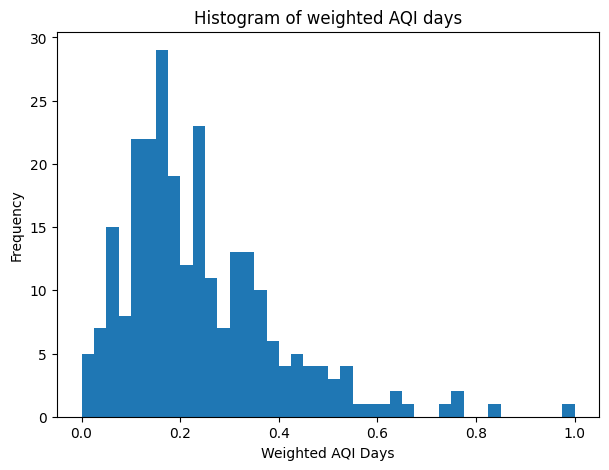

In [15]:
df_air_by_county['Weighted AQI Days'] = (
        df_air_by_county['Weighted AQI Days'] - df_air_by_county['Weighted AQI Days'].min()
    ) / (df_air_by_county['Weighted AQI Days'].max() - df_air_by_county['Weighted AQI Days'].min())

# plot histogram of number of Weighted AQI Days
plt.figure(figsize=(7, 5))
plt.hist(df_air_by_county['Weighted AQI Days'], bins=40)
plt.xlabel('Weighted AQI Days')
plt.ylabel('Frequency')
plt.title('Histogram of weighted AQI days')
plt.show()


257
0.1856705745266261
248


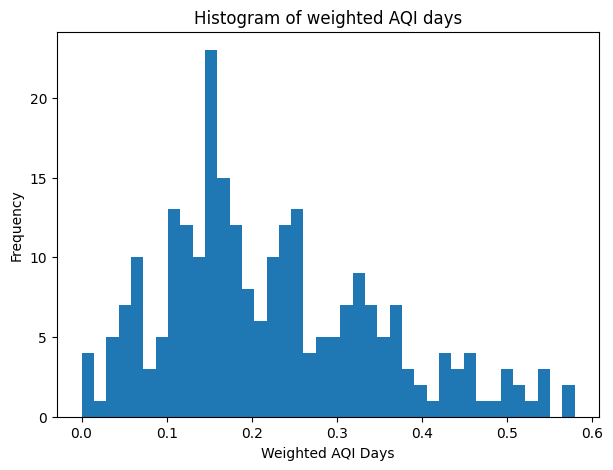

Rows removed: 9


In [16]:
# Drop outliers based on IQR

Q1 = df_air_by_county['Weighted AQI Days'].quantile(0.25)
Q3 = df_air_by_county['Weighted AQI Days'].quantile(0.75)
iqr_value = Q3-Q1
lower_bound = Q1 - 1.5 * iqr_value
upper_bound = Q3 + 1.5 * iqr_value

print(len(df_air_by_county))

df_air_by_county_prenorm = df_air_by_county
print(iqr_value)
df_air_by_county = df_air_by_county[
    (df_air_by_county['Weighted AQI Days'] >= lower_bound) &
    (df_air_by_county['Weighted AQI Days'] <= upper_bound)
]
print(len(df_air_by_county))

# replot 
plt.figure(figsize=(7, 5))
plt.hist(df_air_by_county['Weighted AQI Days'], bins=40)
plt.xlabel('Weighted AQI Days')
plt.ylabel('Frequency')
plt.title('Histogram of weighted AQI days')
plt.show()

rows_removed = df_air_by_county_prenorm.shape[0] - df_air_by_county.shape[0]
print(f"Rows removed: {rows_removed}") # Dropping 9 datapoints out of 257 = 3.5%


<Axes: xlabel='CountyName', ylabel='Weighted AQI Days'>

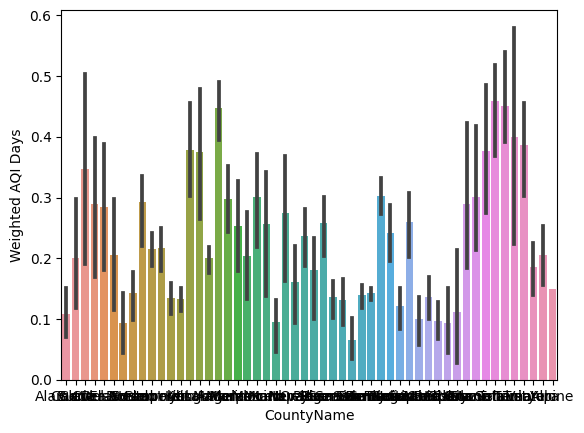

In [17]:
# Bar plot of AQI by county
seaborn.barplot(data = df_air_by_county, x="CountyName", y="Weighted AQI Days")

## Merging Datasets

In [18]:
df_hospital_pop_bycounty = df_hospital_pop_bycounty.rename(columns={"YEAR": "Year"})

In [19]:
df_air_by_county["Year"] = df_air_by_county["Year"].astype("int64")

/var/folders/1d/gjghwm397n7cr3rpcndcs8rh0000gn/T/ipykernel_59560/1382800522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air_by_county["Year"] = df_air_by_county["Year"].astype("int64")


In [20]:
# cleanup for merging

df_hospital_pop_bycounty.rename(columns={'YEAR': 'Year'}, inplace=True)
df_air_by_county['Year'] = df_air_by_county['Year'].astype('int64')


/var/folders/1d/gjghwm397n7cr3rpcndcs8rh0000gn/T/ipykernel_59560/96412565.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air_by_county['Year'] = df_air_by_county['Year'].astype('int64')


In [21]:
# merge AQI and hospital data
df_hospital_aqi = pd.merge(df_hospital_pop_bycounty[["CountyName", "Year", "VisitRate"]], df_air_by_county, on=["Year", "CountyName"], how='inner')
print(len(df_hospital_aqi))
df_hospital_aqi["Weighted AQI Days"] = df_hospital_aqi["Weighted AQI Days"].astype(float)

247


<Axes: xlabel='Weighted AQI Days', ylabel='VisitRate'>

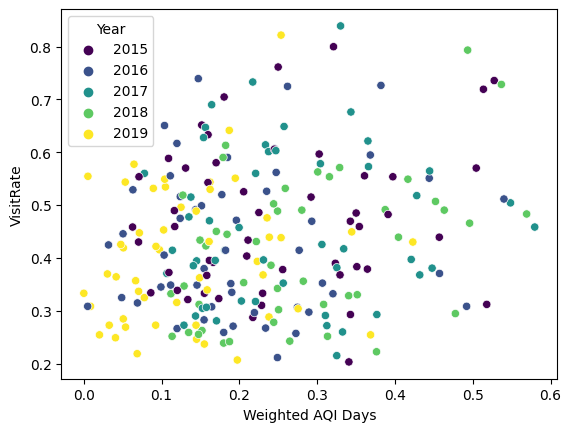

In [22]:
seaborn.scatterplot(data=df_hospital_aqi, x='Weighted AQI Days', y='VisitRate', hue='Year', palette='viridis')

## Linear regression of visit rates vs weighted aqi days

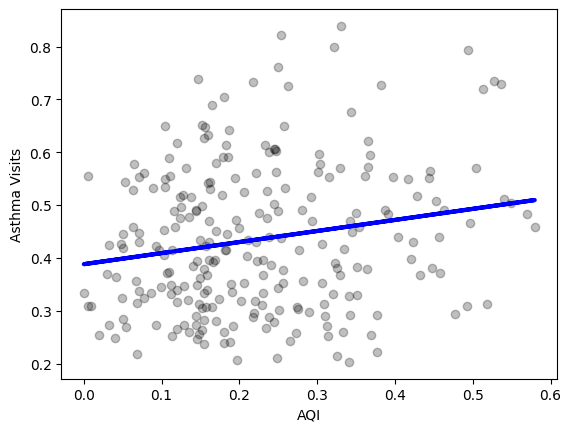

In [23]:
import statsmodels.api as sm

df_hospital_aqi = df_hospital_aqi.dropna(subset=['VisitRate', 'Weighted AQI Days'])

x = df_hospital_aqi["Weighted AQI Days"]
y = df_hospital_aqi["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2 = sm.add_constant(x)

# Fit the simple linear regression
sm_model = sm.OLS(y, x2)
results = sm_model.fit()

# Make predictions using the linear regression
y_pred = results.predict(x2)

# Plot 
plt.scatter(x, y,  color='black', alpha = 0.25)
plt.plot(x, y_pred, color='blue', linewidth=3)
plt.xlabel('AQI')
plt.ylabel('Asthma Visits')
plt.show()

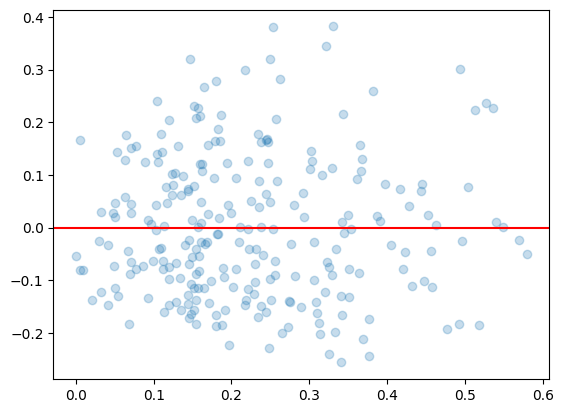

In [24]:
# Enter code here to plot the residuals (Question 7a)
residuals = y - y_pred
plt.scatter(x, residuals, alpha = 0.25)
plt.axhline(y=0, color = 'red')
plt.show()

In [25]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     9.528
Date:                Fri, 20 Dec 2024   Prob (F-statistic):            0.00226
Time:                        13:37:43   Log-Likelihood:                 143.92
No. Observations:                 247   AIC:                            -283.8
Df Residuals:                     245   BIC:                            -276.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3881      0.01

## Get meteorology data

In [26]:
file_path = 'data_meteorolgy.csv'  # File name provided
df = pd.read_csv(file_path)

# Convert the 'Date' column to datetime format if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Extract the year from the 'Date' column
df['Year'] = df['Date'].dt.year

# County and corresponding station map
county_station_map = {
    "Fresno": [2, 7, 39, 80, 105, 124, 205],
    "Kern": [5, 125, 146, 257],
    "Yolo": [6, 226],
    "Butte": [12, 244],
    "El Dorado": [13, 228],
    "Kings": [15],
    "Inyo": [35, 183],
    "Imperial": [41, 68, 87, 175, 181],
    "Shasta": [43, 224],
    "Riverside": [44, 62, 135, 136, 151, 179, 200, 208, 218, 237, 239, 240],
    "Contra Costa": [47, 170, 178, 213, 247],
    "San Luis Obispo": [52, 160, 163, 202, 265, 266],
    "Santa Barbara": [64, 88, 107, 165, 231, 232],
    "San Joaquin": [70, 242, 248, 249, 262],
    "Stanislaus": [71, 194, 206],
    "Orange": [75, 241, 245],
    "Napa": [77],
    "Los Angeles": [78, 99, 159, 174, 197, 204, 215, 216, 219, 220, 223],
    "Sonoma": [103, 144, 158, 83],
    "Yuba": [84],
    "Modoc": [90],
    "Siskiyou": [91, 225, 236, 260, 261],
    "Santa Cruz": [104, 209],
    "Mendocino": [106],
    "Monterey": [113, 114, 116, 129, 193, 210, 214, 229, 252],
    "San Bernardino": [117, 192, 199, 221, 233, 251],
    "San Benito": [126, 143],
    "Sacramento": [131, 140, 243],
    "San Diego": [147, 150, 153, 173, 184, 207],
    "Ventura": [152, 217],
    "Marin": [157, 187],
    "Tulare": [258, 182],
    "Alameda": [191, 254, 171],
    "Placer": [195],
    "Santa Clara": [211],
    "Tehama": [222],
    "Amador": [227],
    "Sutter": [235],
    "Alpine": [246],
    "Colusa": [250],
    "San Mateo": [253],
    "Humboldt": [259],
    "Del Norte": [263],
    "Plumas": [264],
    "Lassen": [267, 268],
    "San Francisco": [191, 178, 170, 47, 213, 247, 254],
    "Solano": [139, 212]
}

# Create a new DataFrame for county-level maximum averages
county_averages = []

# Iterate over each county and its corresponding stations
for county, stations in county_station_map.items():
    # Filter data for the specific stations
    county_data = df[df['Stn Id'].isin(stations)]
#     print(county_data)
    
    # Group the data by year and calculate the averages
    for date, group in county_data.groupby('Date'):
        avg_row = {
            "CountyName": county,
            "Date": date,
            "Avg Max Air Temp (F)": group["Max Air Temp (F)"].mean(),
            "Avg Max Rel Hum (%)": group["Max Rel Hum (%)"].mean()
        }
        county_averages.append(avg_row)

# Convert the list of averages to a DataFrame
county_df = pd.DataFrame(county_averages)

# county_df[county_df["CountyName"] == "Yolo"]

# # Save the county averages to a new CSV file
output_file = 'county_max_averages_daily.csv'
county_df.to_csv(output_file, index=False)



In [27]:
county_df['CountyName'].unique()

array(['Fresno', 'Kern', 'Yolo', 'Butte', 'El Dorado', 'Kings', 'Inyo',
       'Imperial', 'Shasta', 'Riverside', 'Contra Costa',
       'San Luis Obispo', 'Santa Barbara', 'San Joaquin', 'Stanislaus',
       'Orange', 'Napa', 'Los Angeles', 'Sonoma', 'Yuba', 'Modoc',
       'Siskiyou', 'Santa Cruz', 'Mendocino', 'Monterey',
       'San Bernardino', 'San Benito', 'Sacramento', 'San Diego',
       'Ventura', 'Marin', 'Tulare', 'Alameda', 'Placer', 'Santa Clara',
       'Tehama', 'Amador', 'Sutter', 'Alpine', 'Colusa', 'San Mateo',
       'Humboldt', 'Del Norte', 'Plumas', 'San Francisco', 'Solano'],
      dtype=object)

In [28]:
# Load the dataset
df_meteor = pd.read_csv('county_max_averages_daily.csv')

# Heat index calculation using the simplified formula
df_meteor['Heat Index'] = (0.5 * (
    df_meteor['Avg Max Air Temp (F)'] + 61 +
    ((df_meteor['Avg Max Air Temp (F)'] - 68) * 1.2) +
    (df_meteor['Avg Max Rel Hum (%)'] * 0.094)
) + df_meteor['Avg Max Air Temp (F)']) / 2

# Heat index calculation using the Rothfusz regression equation for HI > 80
df_meteor.loc[
    df_meteor['Heat Index'] > 80, 'Heat Index'
] = -42.379 + 2.04901523 * df_meteor['Avg Max Air Temp (F)'] + \
    10.14333127 * df_meteor['Avg Max Rel Hum (%)'] - \
    0.22475541 * df_meteor['Avg Max Air Temp (F)'] * df_meteor['Avg Max Rel Hum (%)'] - \
    0.00683783 * df_meteor['Avg Max Air Temp (F)']**2 - \
    0.05481717 * df_meteor['Avg Max Rel Hum (%)']**2 + \
    0.00122874 * df_meteor['Avg Max Rel Hum (%)'] * df_meteor['Avg Max Air Temp (F)']**2 + \
    0.00085282 * df_meteor['Avg Max Air Temp (F)'] * df_meteor['Avg Max Rel Hum (%)']**2 - \
    0.00000199 * (df_meteor['Avg Max Air Temp (F)']**2) * df_meteor['Avg Max Rel Hum (%)']**2

# Adjustment for RH < 13 and 80 < T < 112
df_meteor.loc[
    (df_meteor['Avg Max Rel Hum (%)'] < 13) &
    (df_meteor['Avg Max Air Temp (F)'] > 80) &
    (df_meteor['Avg Max Air Temp (F)'] < 112),
    'Heat Index'
] -= ((13 - df_meteor['Avg Max Rel Hum (%)']) / 4) * np.sqrt(
    (17 - np.abs(df_meteor['Avg Max Air Temp (F)'] - 95)) / 17
)

# Adjustment for RH > 85 and 80 < T < 87
df_meteor.loc[
    (df_meteor['Avg Max Rel Hum (%)'] > 85) &
    (df_meteor['Avg Max Air Temp (F)'] > 80) &
    (df_meteor['Avg Max Air Temp (F)'] < 87),
    'Heat Index'
] += ((df_meteor['Avg Max Rel Hum (%)'] - 85) / 10) * \
    ((87 - df_meteor['Avg Max Air Temp (F)']) / 5)

# Display the first few rows of the updated dataframe
df_meteor['Year'] = pd.to_datetime(df_meteor['Date']).dt.year
df_meteor.head(n=10)
print(df_meteor['CountyName'].unique())


['Fresno' 'Kern' 'Yolo' 'Butte' 'El Dorado' 'Kings' 'Inyo' 'Imperial'
 'Shasta' 'Riverside' 'Contra Costa' 'San Luis Obispo' 'Santa Barbara'
 'San Joaquin' 'Stanislaus' 'Orange' 'Napa' 'Los Angeles' 'Sonoma' 'Yuba'
 'Modoc' 'Siskiyou' 'Santa Cruz' 'Mendocino' 'Monterey' 'San Bernardino'
 'San Benito' 'Sacramento' 'San Diego' 'Ventura' 'Marin' 'Tulare'
 'Alameda' 'Placer' 'Santa Clara' 'Tehama' 'Amador' 'Sutter' 'Alpine'
 'Colusa' 'San Mateo' 'Humboldt' 'Del Norte' 'Plumas' 'San Francisco'
 'Solano']


/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Function to calculate weighted heat index days

In [29]:
# Class 1: 80-90, Class 2: 90-103, Class 3: 103-124, Class 4: >125
def make_weighted_hi_days_df(df):
        counts_df = pd.DataFrame(columns=['CountyName', 'Year', 'Weighted HI Days'])

        for year in df['Year'].unique():
                year_df = df[df['Year'] == year]
                for county in df['CountyName'].unique():
                        county_year_df = year_df[year_df['CountyName'] == county]
                        class_4 = (county_year_df['Heat Index'] > 125).sum()
                        class_3 = ((county_year_df['Heat Index'] > 103) & (county_year_df['Heat Index'] <= 125)).sum()
                        class_2 = ((county_year_df['Heat Index'] > 90) & (county_year_df['Heat Index'] <= 103)).sum()
                        class_1 = ((county_year_df['Heat Index'] > 80) & (county_year_df['Heat Index'] <= 90)).sum()

                        weighted_sum = 4 * class_4 + 3 * class_3 + 2 * class_2 + class_1

                        new_df_row = pd.DataFrame([[county, year, weighted_sum]], columns=['CountyName', 'Year', 'Weighted HI Days'])
                        counts_df = pd.concat([counts_df, new_df_row])

        return counts_df

In [30]:
df_meteor = df_meteor[["CountyName", "Heat Index", "Year"]]
heat_index_df = make_weighted_hi_days_df(df_meteor)

# Scaling between 0 and 1
# heat_index_df['Weighted HI Days'] = (
#         heat_index_df['Weighted HI Days'] - heat_index_df['Weighted HI Days'].min()
#     ) / (heat_index_df['Weighted HI Days'].max() - heat_index_df['Weighted HI Days'].min())


print(set(CA_counties) - set(heat_index_df['CountyName'].unique()))

{'Nevada', 'Lake', 'Calaveras', 'Merced', 'Madera', 'Trinity', 'Mono', 'Glenn', 'Mariposa'}


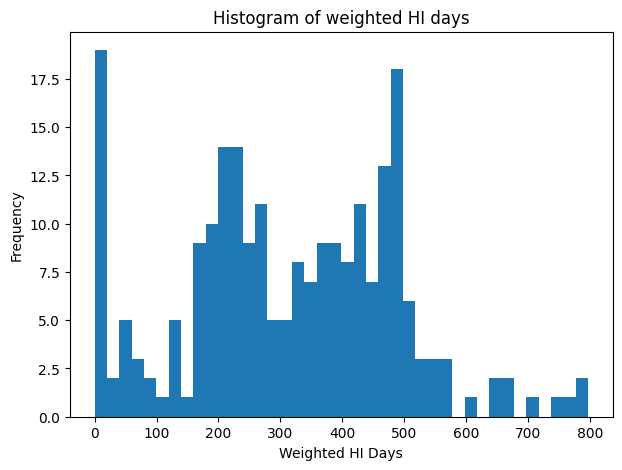

In [31]:
# plot histogram of number of Weighted AQI Days
plt.figure(figsize=(7, 5))
plt.hist(heat_index_df['Weighted HI Days'], bins=40)
plt.xlabel('Weighted HI Days')
plt.ylabel('Frequency')
plt.title('Histogram of weighted HI days')
plt.show()

## Comparing included and excluded counties for feature, response

In [32]:
df_hospital_aqi_heat = pd.merge(df_hospital_aqi[["CountyName", "Year", "VisitRate", "Weighted AQI Days"]], heat_index_df, on=["Year", "CountyName"], how='inner')
df_hospital_aqi_heat["Weighted HI Days"] = df_hospital_aqi_heat["Weighted HI Days"].astype(float)

In [33]:
# Get CA counties we're using
used_county_list = df_hospital_aqi_heat['CountyName'].unique()
dropped_county_list = set(CA_counties) - set(used_county_list)
print("excluding: ", dropped_county_list)

excluding:  {'Nevada', 'Lake', 'Calaveras', 'Merced', 'Madera', 'Trinity', 'Mono', 'Glenn', 'Mariposa'}


In [34]:
# t test for visit rate
#hypothesis testing for visit rate
from scipy.stats import ttest_ind

# Split the data into 'used' and 'dropped' counties
used_counties = df_hospital_bycounty[df_hospital_bycounty['CountyName'].isin(used_county_list)]
dropped_counties = df_hospital_bycounty[df_hospital_bycounty['CountyName'].isin(dropped_county_list)] 
# print(dropped_counties)

# Perform the t-test for 'VisitRate'
used_visit_rate = used_counties['AGE-ADJUSTED ED VISIT RATE']
dropped_visit_rate = dropped_counties['AGE-ADJUSTED ED VISIT RATE']

# T-test
t_stat, p_value = ttest_ind(used_visit_rate, dropped_visit_rate, equal_var=False)  # Welch's t-test if unequal variances

print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: -2.3306853783616956, P-value: 0.023250999776907203


In [35]:
#check for normality
from scipy.stats import shapiro

stat_used, p_used = shapiro(used_visit_rate)
stat_dropped, p_dropped = shapiro(dropped_visit_rate)

print(f"Shapiro-Wilk Test for Used Counties: p-value = {p_used}")
print(f"Shapiro-Wilk Test for Dropped Counties: p-value = {p_dropped}")

# Not normal so T-statistic above invalid

Shapiro-Wilk Test for Used Counties: p-value = 5.417294232756831e-05
Shapiro-Wilk Test for Dropped Counties: p-value = 0.0241425558924675


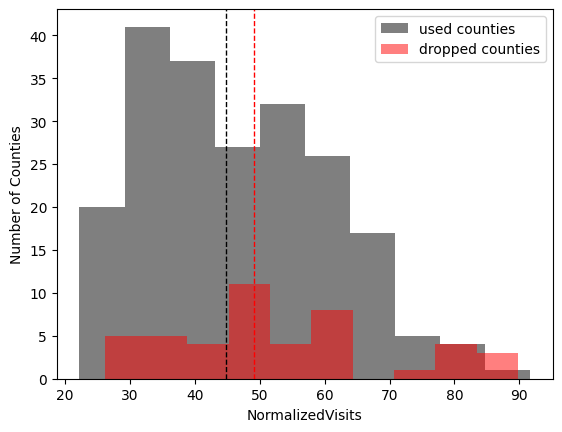

The p-value for the Moods Median test is  0.09458625486213693
The grand median (median for all both samples together) is  46.2
The contingency table is: 
 [[ 99  28]
 [111  17]]
There is NOT a statistically significant difference between the included and excluded counties


In [36]:
# Moods median for ED visits
plt.hist(used_counties['AGE-ADJUSTED ED VISIT RATE'], 
         alpha=0.5, 
         color='black',
         label='used counties')
  
plt.hist(dropped_counties['AGE-ADJUSTED ED VISIT RATE'],
         alpha=0.5,
         color = 'red',
         label='dropped counties')

plt.axvline(used_counties['AGE-ADJUSTED ED VISIT RATE'].median(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(dropped_counties['AGE-ADJUSTED ED VISIT RATE'].median(), color='red', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('NormalizedVisits')
plt.ylabel('Number of Counties')
plt.show()


stat, p, med, tbl = median_test(used_counties['AGE-ADJUSTED ED VISIT RATE'], dropped_counties['AGE-ADJUSTED ED VISIT RATE'])
print('The p-value for the Moods Median test is ', p)
print('The grand median (median for all both samples together) is ', med)
print('The contingency table is: \n', tbl)
("For ED Visit Rate:")
if (p < 0.01):
        print("There IS a statistically significant difference between the included and excluded counties")
else: 
        print("There is NOT a statistically significant difference between the included and excluded counties")

Index(['index', 'CountyName', 'Weighted AQI Days', 'Year'], dtype='object')


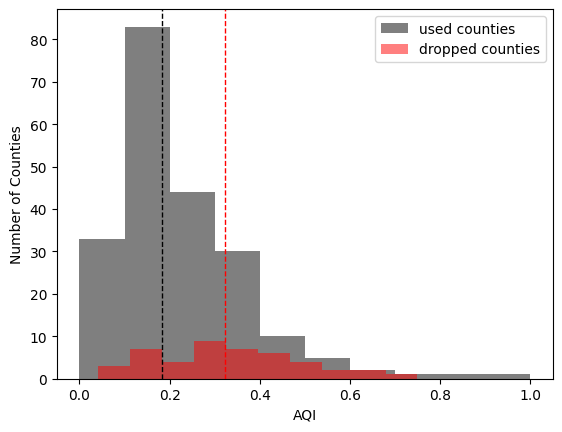

The p-value for the Moods Median test is  7.143285656907468e-05
The grand median (median for all both samples together) is  0.20548075715387945
The contingency table is: 
 [[ 92  35]
 [118  10]]
There IS a statistically significant difference between the included and excluded counties


/var/folders/1d/gjghwm397n7cr3rpcndcs8rh0000gn/T/ipykernel_59560/2918791265.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  used_counties['Weighted AQI Days'] = pd.to_numeric(used_counties['Weighted AQI Days'], errors='coerce')
/var/folders/1d/gjghwm397n7cr3rpcndcs8rh0000gn/T/ipykernel_59560/2918791265.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped_counties['Weighted AQI Days'] = pd.to_numeric(dropped_counties['Weighted AQI Days'], errors='coerce')


In [37]:
# Moods median for AQI
# Split the data into 'used' and 'dropped' counties
print(df_air_by_county_prenorm.columns)
used_counties = df_air_by_county_prenorm[df_air_by_county_prenorm['CountyName'].isin(used_county_list)]
dropped_counties = df_air_by_county_prenorm[df_air_by_county_prenorm['CountyName'].isin(dropped_county_list)] 

plt.hist(used_counties['Weighted AQI Days'], 
         alpha=0.5, 
         color='black',
         label='used counties')
  
plt.hist(dropped_counties['Weighted AQI Days'],
         alpha=0.5,
         color = 'red',
         label='dropped counties')

plt.axvline(used_counties['Weighted AQI Days'].median(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(dropped_counties['Weighted AQI Days'].median(), color='red', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('AQI')
plt.ylabel('Number of Counties')
plt.show()

used_counties['Weighted AQI Days'] = pd.to_numeric(used_counties['Weighted AQI Days'], errors='coerce')
dropped_counties['Weighted AQI Days'] = pd.to_numeric(dropped_counties['Weighted AQI Days'], errors='coerce')

stat, p, med, tbl = median_test(used_counties['Weighted AQI Days'], dropped_counties['Weighted AQI Days'])
print('The p-value for the Moods Median test is ', p)
print('The grand median (median for all both samples together) is ', med)
print('The contingency table is: \n', tbl)
("For ED Visit Rate:")
if (p < 0.01):
        print("There IS a statistically significant difference between the included and excluded counties")
else: 
        print("There is NOT a statistically significant difference between the included and excluded counties")

## Multivariate linear regression

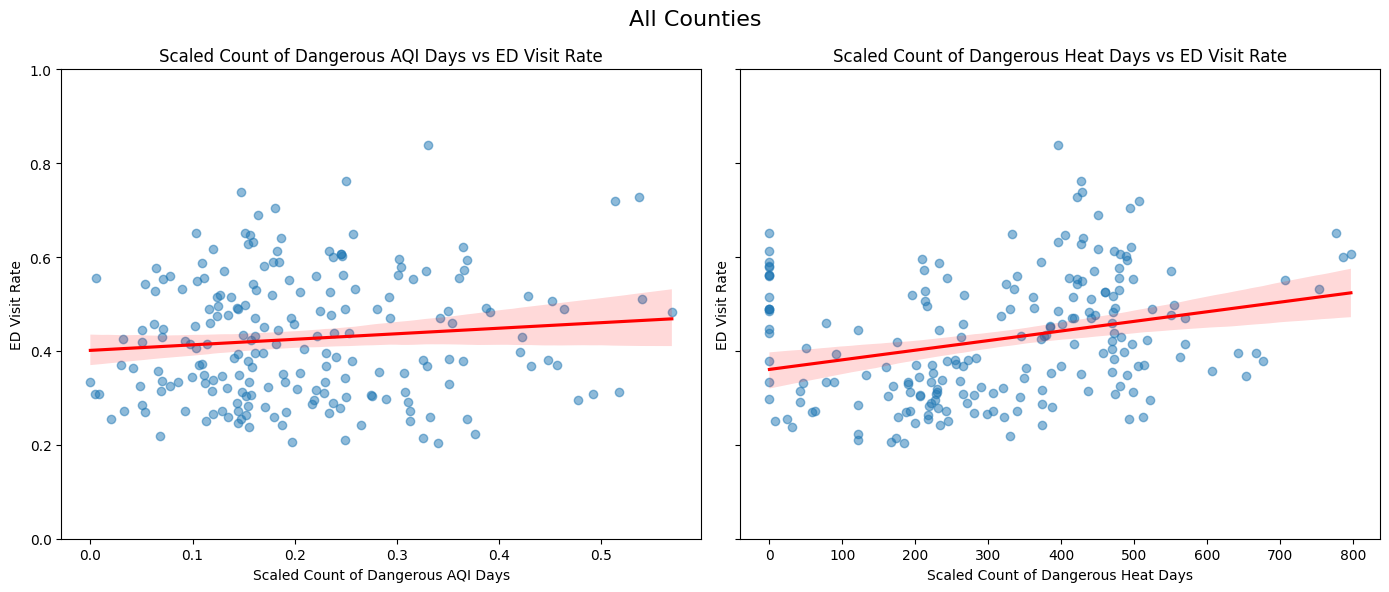

                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     9.328
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           0.000133
Time:                        13:37:52   Log-Likelihood:                 134.49
No. Observations:                 205   AIC:                            -263.0
Df Residuals:                     202   BIC:                            -253.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3493      0.02

In [38]:
# linear regression on all
regression_df = df_hospital_aqi_heat

x = df_hospital_aqi_heat[["Weighted AQI Days", "Weighted HI Days"]]
y = df_hospital_aqi_heat["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2 = sm.add_constant(x)

# Fit the simple linear regression
sm_model = sm.OLS(y, x2)
results= sm_model.fit()

# Make predictions using the linear regression
y_pred = results.predict(x2)

import seaborn as sns
import matplotlib.pyplot as plt

# Add predicted VisitRate to the DataFrame
regression_df["VisitRate_Pred"] = y_pred

# Plotting the relationship between each predictor and VisitRate
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot 1: Weighted AQI Days vs VisitRate
sns.regplot(
    ax=axes[0],
    x="Weighted AQI Days",
    y="VisitRate",
    data=regression_df,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[0].set_ylim(0, 1)
axes[0].set_title("Scaled Count of Dangerous AQI Days vs ED Visit Rate")
axes[0].set_xlabel("Scaled Count of Dangerous AQI Days")
axes[0].set_ylabel("ED Visit Rate")

# Plot 2: Weighted HI Days vs VisitRate
sns.regplot(
    ax=axes[1],
    x="Weighted HI Days",
    y="VisitRate",
    data=regression_df,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[1].set_ylim(0, 1)
axes[1].set_title("Scaled Count of Dangerous Heat Days vs ED Visit Rate")
axes[1].set_xlabel("Scaled Count of Dangerous Heat Days")
axes[1].set_ylabel("ED Visit Rate")

fig.suptitle("All Counties", fontsize=16)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

print(results.summary())

In [39]:
full_data_residuals = results.resid
d = {'residuals':results.resid, 'CountyName':regression_df['CountyName']}
resids_df = pd.DataFrame(data = d)
resids_df

,residuals,CountyName
0,0.185945,Alameda
1,0.133271,Alameda
2,0.085372,Alameda
3,0.059030,Alameda
4,0.031800,Alameda
...,...,...
200,-0.052346,Yolo
201,-0.094841,Yolo
202,-0.058722,Yolo
203,-0.104747,Yolo


In [40]:
from scipy.stats import shapiro

print("TOTAL DATA")
stat, p_value = shapiro(results.resid)
# print("Shapiro-Wilk Test Statistic:", stat)
# print("p-value:", p_value)
if p_value > 0.01:
    print("Residuals appear to be normally distributed (fail to reject H0).")
else:
    print("Residuals do not appear to be normally distributed (reject H0).")


TOTAL DATA
Residuals do not appear to be normally distributed (reject H0).


## Dividing along poverty lines

In [41]:
df_poverty = pd.read_csv('HDPulse_data_export.csv')
df_poverty = df_poverty[["County", "Value (Percent)"]]
df_poverty[">= 10%"] = df_poverty["Value (Percent)"] >= 10.0
df_poverty = df_poverty[~df_poverty["County"].isin(["United States", "California"])]
df_poverty.reset_index(drop=True, inplace=True)
df_poverty[">= 10%"] = df_poverty[">= 10%"].astype(int)
df_poverty = df_poverty.rename(columns={"County" : "CountyName"})
df_poverty["CountyName"] = df_poverty["CountyName"].str.replace(" County", "", regex=False)

In [42]:
df_hospital_aqi_poverty = pd.merge(df_poverty[["CountyName", ">= 10%"]], df_hospital_aqi, on=["CountyName"])
print(len(df_hospital_aqi_poverty))
df_hospital_aqi_poverty.head()

247


,CountyName,>= 10%,Year,VisitRate,index,Weighted AQI Days
0,Imperial,1,2015,0.651418,0,0.151561
1,Imperial,1,2016,0.606587,0,0.245197
2,Imperial,1,2017,0.601098,0,0.237502
3,Imperial,1,2018,0.531565,0,0.258932
4,Imperial,1,2019,0.550778,0,0.194676


In [43]:
df_hospital_aqi_heat_poverty = pd.merge(df_hospital_aqi_heat, df_hospital_aqi_poverty, on=["Year", "CountyName", "VisitRate", "Weighted AQI Days"], how='inner')
df_hospital_aqi_heat_poverty

,CountyName,Year,VisitRate,Weighted AQI Days,Weighted HI Days,VisitRate_Pred,>= 10%,index
0,Alameda,2015,0.588289,0.108904,232.0,0.402344,0,0
1,Alameda,2016,0.528820,0.063094,213.0,0.395549,0,0
2,Alameda,2017,0.515096,0.137614,361.0,0.429724,0,0
3,Alameda,2018,0.444648,0.184087,122.0,0.385617,0,0
4,Alameda,2019,0.419030,0.050837,175.0,0.387230,0,0
...,...,...,...,...,...,...,...,...
200,Yolo,2015,0.403477,0.209451,469.0,0.455823,0,0
201,Yolo,2016,0.351327,0.188953,427.0,0.446168,0,0
202,Yolo,2017,0.396157,0.230908,457.0,0.454879,0,0
203,Yolo,2018,0.355901,0.282086,469.0,0.460649,0,0


In [44]:
poverty_county_data = df_hospital_aqi_heat_poverty[df_hospital_aqi_heat_poverty[">= 10%"] == True]
not_poverty_county_data = df_hospital_aqi_heat_poverty[df_hospital_aqi_heat_poverty[">= 10%"] == False]

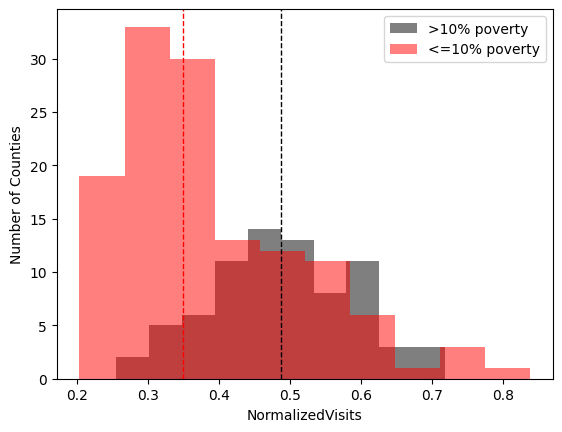

The p-value for the Moods Median test is  2.5817627061890172e-11
The grand median (median for all both samples together) is  0.414455626715462
The contingency table is: 
 [[61 40]
 [15 89]]
There IS a statistically significant difference between the two poverty groups


In [45]:
plt.hist(poverty_county_data['VisitRate'], 
         alpha=0.5, # the transaparency parameter
         color='black',
         label='>10% poverty')
  
plt.hist(not_poverty_county_data['VisitRate'],
         alpha=0.5,
         color = 'red',
         label='<=10% poverty')

plt.axvline(poverty_county_data['VisitRate'].median(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(not_poverty_county_data['VisitRate'].median(), color='red', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('NormalizedVisits')
plt.ylabel('Number of Counties')
plt.show()


stat, p, med, tbl = median_test(poverty_county_data['VisitRate'], not_poverty_county_data['VisitRate'])
print('The p-value for the Moods Median test is ', p)
print('The grand median (median for all both samples together) is ', med)
print('The contingency table is: \n', tbl)
("For ED Visit Rate:")
if (p < 0.01):
        print("There IS a statistically significant difference between the two poverty groups")
else: 
        print("There is NOT a statistically significant difference between the two poverty groups")

Index(['CountyName', 'YEAR', 'AGE-ADJUSTED ED VISIT RATE'], dtype='object')


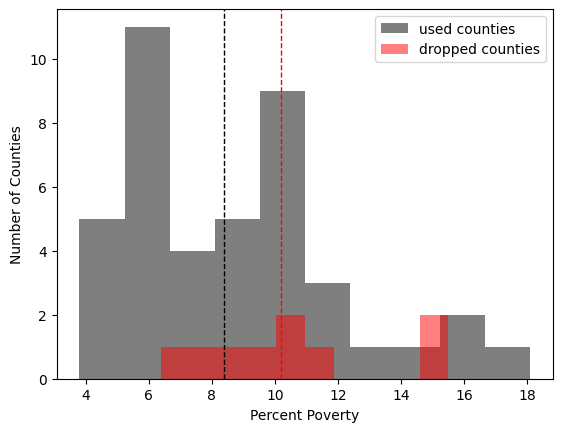

The p-value for the Moods Median test is  0.42393969840526824
The grand median (median for all both samples together) is  9.0
The contingency table is: 
 [[19  6]
 [23  3]]
There is NOT a statistically significant difference between the included and excluded counties


In [46]:
# split poverty by use
used_counties = df_hospital_bycounty[df_hospital_bycounty['CountyName'].isin(used_county_list)]
print(df_hospital_bycounty.columns)
dropped_counties = df_hospital_bycounty[df_hospital_bycounty['CountyName'].isin(dropped_county_list)] #TODO this info not included obvi so get from og sources

# Split poverty by 'used' and 'dropped' counties
used_counties = df_poverty[df_poverty['CountyName'].isin(used_county_list)]
dropped_counties = df_poverty[df_poverty['CountyName'].isin(dropped_county_list)] #TODO this info not included obvi so get from og sources

# Moods median for poverty
plt.hist(used_counties['Value (Percent)'], 
         alpha=0.5, 
         color='black',
         label='used counties')
  
plt.hist(dropped_counties['Value (Percent)'],
         alpha=0.5,
         color = 'red',
         label='dropped counties')

plt.axvline(used_counties['Value (Percent)'].median(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(dropped_counties['Value (Percent)'].median(), color='red', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('Percent Poverty')
plt.ylabel('Number of Counties')
plt.show()


stat, p, med, tbl = median_test(used_counties['Value (Percent)'], dropped_counties['Value (Percent)'])
print('The p-value for the Moods Median test is ', p)
print('The grand median (median for all both samples together) is ', med)
print('The contingency table is: \n', tbl)
("For ED Visit Rate:")
if (p < 0.01):
        print("There IS a statistically significant difference between the included and excluded counties")
else: 
        print("There is NOT a statistically significant difference between the included and excluded counties")

/var/folders/1d/gjghwm397n7cr3rpcndcs8rh0000gn/T/ipykernel_59560/4130651876.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_poverty_county_data["VisitRate_Pred"] = y_pred_no_pov


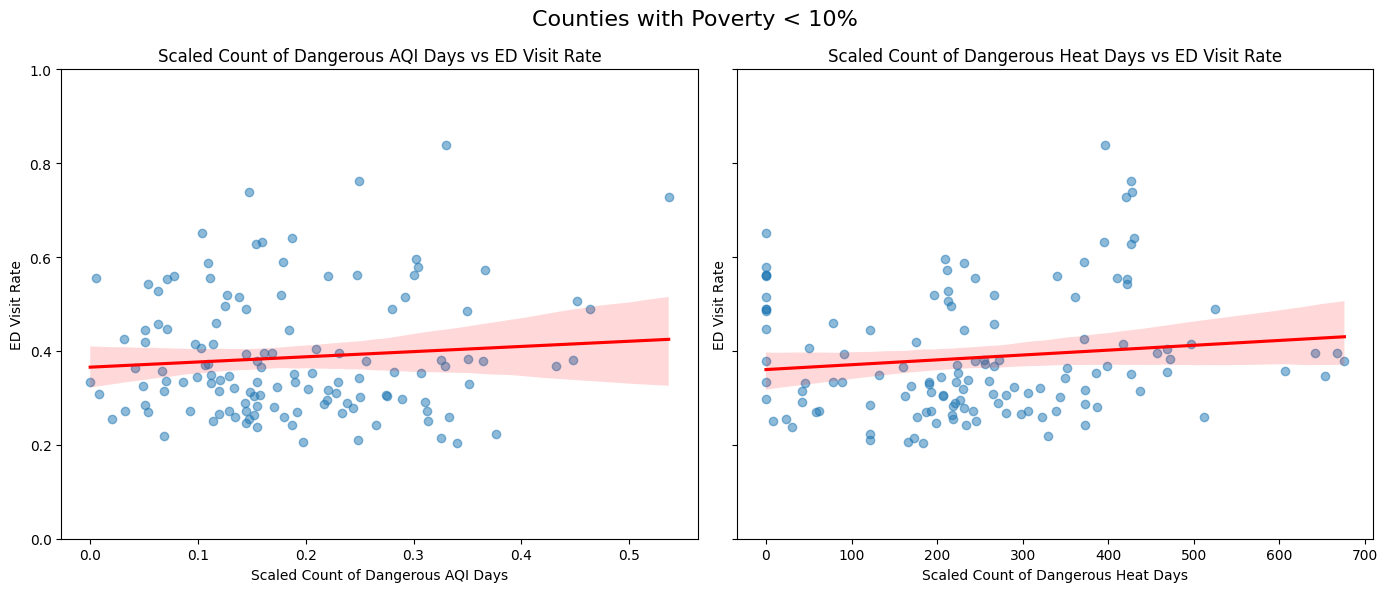

                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.586
Date:                Fri, 20 Dec 2024   Prob (F-statistic):              0.209
Time:                        13:37:52   Log-Likelihood:                 81.380
No. Observations:                 129   AIC:                            -156.8
Df Residuals:                     126   BIC:                            -148.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3393      0.02

In [47]:
# linear regression on < 10% poverty 

x_no_pov = not_poverty_county_data[["Weighted AQI Days", "Weighted HI Days"]]
y_no_pov = not_poverty_county_data["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2_no_pov = sm.add_constant(x_no_pov)

# Fit the simple linear regression
sm_model_no_pov = sm.OLS(y_no_pov, x2_no_pov)
results_no_pov= sm_model_no_pov.fit()

# Make predictions using the linear regression
y_pred_no_pov = results_no_pov.predict(x2_no_pov)

import seaborn as sns
import matplotlib.pyplot as plt

# Add predicted VisitRate to the DataFrame
not_poverty_county_data["VisitRate_Pred"] = y_pred_no_pov

# Plotting the relationship between each predictor and VisitRate
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot 1: Weighted AQI Days vs VisitRate
sns.regplot(
    ax=axes[0],
    x="Weighted AQI Days",
    y="VisitRate",
    data=not_poverty_county_data,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[0].set_ylim(0, 1)
axes[0].set_title("Scaled Count of Dangerous AQI Days vs ED Visit Rate")
axes[0].set_xlabel("Scaled Count of Dangerous AQI Days")
axes[0].set_ylabel("ED Visit Rate")

# Plot 2: Weighted HI Days vs VisitRate
sns.regplot(
    ax=axes[1],
    x="Weighted HI Days",
    y="VisitRate",
    data=not_poverty_county_data,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[1].set_ylim(0, 1)
axes[1].set_title("Scaled Count of Dangerous Heat Days vs ED Visit Rate")
axes[1].set_xlabel("Scaled Count of Dangerous Heat Days")
axes[1].set_ylabel("ED Visit Rate")

fig.suptitle("Counties with Poverty < 10%", fontsize=16)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

print(results_no_pov.summary())

/var/folders/1d/gjghwm397n7cr3rpcndcs8rh0000gn/T/ipykernel_59560/1520898941.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poverty_county_data["VisitRate_Pred"] = y_pred_pov


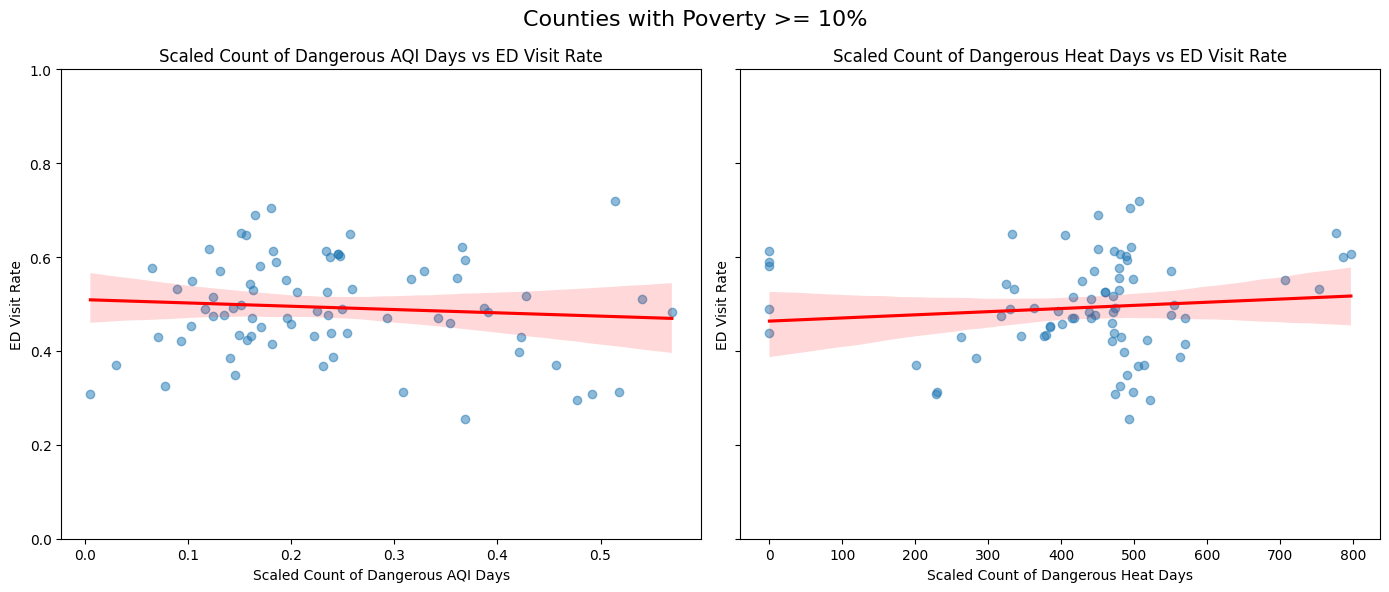

                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8777
Date:                Fri, 20 Dec 2024   Prob (F-statistic):              0.420
Time:                        13:37:53   Log-Likelihood:                 66.285
No. Observations:                  76   AIC:                            -126.6
Df Residuals:                      73   BIC:                            -119.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4789      0.03

In [48]:
x_pov = poverty_county_data[["Weighted AQI Days", "Weighted HI Days"]]
y_pov = poverty_county_data["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2_pov = sm.add_constant(x_pov)

# Fit the simple linear regression
sm_model_pov = sm.OLS(y_pov, x2_pov)
results_pov= sm_model_pov.fit()

# Make predictions using the linear regression
y_pred_pov = results_pov.predict(x2_pov)

# Add predicted VisitRate to the DataFrame
poverty_county_data["VisitRate_Pred"] = y_pred_pov

# Plotting the relationship between each predictor and VisitRate
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot 1: Weighted AQI Days vs VisitRate
sns.regplot(
    ax=axes[0],
    x="Weighted AQI Days",
    y="VisitRate",
    data=poverty_county_data,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[0].set_ylim(0, 1)
axes[0].set_title("Scaled Count of Dangerous AQI Days vs ED Visit Rate")
axes[0].set_xlabel("Scaled Count of Dangerous AQI Days")
axes[0].set_ylabel("ED Visit Rate")

# Plot 2: Weighted HI Days vs VisitRate
sns.regplot(
    ax=axes[1],
    x="Weighted HI Days",
    y="VisitRate",
    data=poverty_county_data,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[1].set_ylim(0, 1)
axes[1].set_title("Scaled Count of Dangerous Heat Days vs ED Visit Rate")
axes[1].set_xlabel("Scaled Count of Dangerous Heat Days")
axes[1].set_ylabel("ED Visit Rate")

fig.suptitle("Counties with Poverty >= 10%", fontsize=16)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

print(results_pov.summary())

## Get Ethnicity Data

In [49]:
df_ethnicity = pd.read_csv('ethnicity.csv', encoding = "ISO-8859-1")
df_ethnicity = df_ethnicity[["Geography", "Total Population - Estimate", "Hispanic or Latino - Estimate"]]
df_ethnicity['Total Population - Estimate'] = df_ethnicity['Total Population - Estimate'].str.replace(',', '', regex=False).astype(float)
df_ethnicity['Hispanic or Latino - Estimate'] = df_ethnicity['Hispanic or Latino - Estimate'].str.replace(',', '', regex=False).astype(float)
df_ethnicity = df_ethnicity[df_ethnicity['Geography'].str.contains('County', case=False, na=False)]
df_ethnicity = df_ethnicity[~df_ethnicity['Geography'].str.contains('County\\)', case=False, na=False)]
df_ethnicity['Geography'] = df_ethnicity['Geography'].str.replace(' County', '', regex=False)
df_ethnicity["Total Population - Estimate"] = pd.to_numeric(df_ethnicity["Total Population - Estimate"], errors='coerce')
df_ethnicity['Hispanic or Latino - Estimate'] = pd.to_numeric(df_ethnicity['Hispanic or Latino - Estimate'], errors='coerce')
df_ethnicity["% Hispanic/Latino"] = df_ethnicity["Hispanic or Latino - Estimate"] / df_ethnicity["Total Population - Estimate"]

df_ethnicity = df_ethnicity[["Geography", "% Hispanic/Latino"]]
df_ethnicity["Majority Hisp"] = df_ethnicity["% Hispanic/Latino"] >= 0.5 
print("Count >= 50%: ",  df_ethnicity["Majority Hisp"].sum() * 5) # multipled for 5 years
print("Count < 50%: ",(df_ethnicity["Majority Hisp"] == 0).sum() * 5)
df_ethnicity = df_ethnicity.rename(columns={"Geography" : "CountyName"})
df_ethnicity["Majority Hisp"] = df_ethnicity["Majority Hisp"].astype(int)
df_ethnicity.head()

Count >= 50%:  55
Count < 50%:  235


,CountyName,% Hispanic/Latino,Majority Hisp
1,Alameda,0.223943,0
22,Alpine,0.125120,0
28,Amador,0.138958,0
47,Butte,0.163478,0
78,Calaveras,0.120600,0


In [50]:
df_hospital_aqi_heat_poverty_ethn = pd.merge(df_hospital_aqi_heat_poverty, df_ethnicity, on=["CountyName"], how='inner')
df_hospital_aqi_heat_poverty_hisp = df_hospital_aqi_heat_poverty_ethn[df_hospital_aqi_heat_poverty_ethn["Majority Hisp"] == 1]
df_hospital_aqi_heat_poverty_not_hisp = df_hospital_aqi_heat_poverty_ethn[df_hospital_aqi_heat_poverty_ethn["Majority Hisp"] == 0]

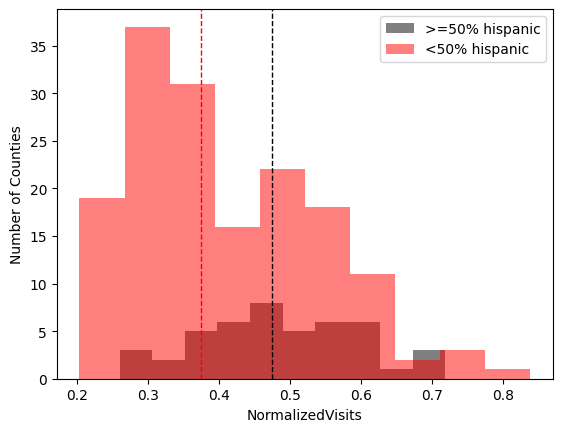

The p-value for the Moods Median test is  0.00013143926278537943
The grand median (median for all both samples together) is  0.414455626715462
The contingency table is: 
 [[34 67]
 [11 93]]
There IS a statistically significant difference between the two hispanic groups


In [51]:
plt.hist(df_hospital_aqi_heat_poverty_hisp['VisitRate'], 
         alpha=0.5, 
         color='black',
         label='>=50% hispanic')
  
plt.hist(df_hospital_aqi_heat_poverty_not_hisp['VisitRate'],
         alpha=0.5,
         color = 'red',
         label='<50% hispanic')

plt.axvline(df_hospital_aqi_heat_poverty_hisp['VisitRate'].median(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(df_hospital_aqi_heat_poverty_not_hisp['VisitRate'].median(), color='red', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('NormalizedVisits')
plt.ylabel('Number of Counties')
plt.show()


stat, p, med, tbl = median_test(df_hospital_aqi_heat_poverty_hisp['VisitRate'], df_hospital_aqi_heat_poverty_not_hisp['VisitRate'])
print('The p-value for the Moods Median test is ', p)
print('The grand median (median for all both samples together) is ', med)
print('The contingency table is: \n', tbl)
("For ED Visit Rate:")
if (p < 0.01):
        print("There IS a statistically significant difference between the two hispanic groups")
else: 
        print("There is NOT a statistically significant difference between the two hispanic groups")

Index(['CountyName', '% Hispanic/Latino', 'Majority Hisp'], dtype='object')


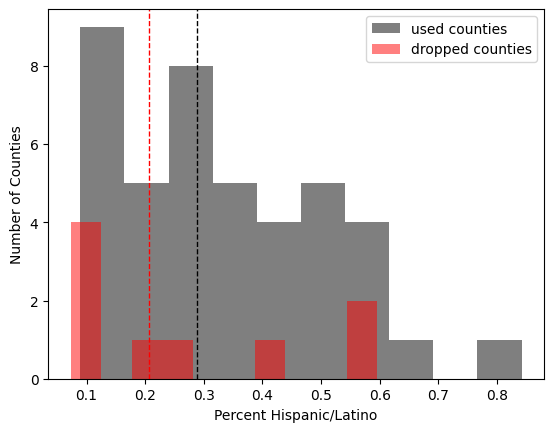

The p-value for the Moods Median test is  1.0
The grand median (median for all both samples together) is  0.26725987050094846
The contingency table is: 
 [[21  4]
 [21  5]]
There is NOT a statistically significant difference between the included and excluded counties


In [52]:
# Split percent hipanic by 'used' and 'dropped' counties
print(df_ethnicity.columns)
used_counties = df_ethnicity[df_ethnicity['CountyName'].isin(used_county_list)]
dropped_counties = df_ethnicity[df_ethnicity['CountyName'].isin(dropped_county_list)] 

# Moods median for percent hispanic
plt.hist(used_counties['% Hispanic/Latino'], 
         alpha=0.5, 
         color='black',
         label='used counties')
  
plt.hist(dropped_counties['% Hispanic/Latino'],
         alpha=0.5,
         color = 'red',
         label='dropped counties')

plt.axvline(used_counties['% Hispanic/Latino'].median(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(dropped_counties['% Hispanic/Latino'].median(), color='red', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('Percent Hispanic/Latino')
plt.ylabel('Number of Counties')
plt.show()


stat, p, med, tbl = median_test(used_counties['% Hispanic/Latino'], dropped_counties['% Hispanic/Latino'])
print('The p-value for the Moods Median test is ', p)
print('The grand median (median for all both samples together) is ', med)
print('The contingency table is: \n', tbl)
("For ED Visit Rate:")
if (p < 0.01):
        print("There IS a statistically significant difference between the included and excluded counties")
else: 
        print("There is NOT a statistically significant difference between the included and excluded counties")

HISPANIC MAJORITY COUNTIES


/var/folders/1d/gjghwm397n7cr3rpcndcs8rh0000gn/T/ipykernel_59560/2169084557.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hospital_aqi_heat_poverty_hisp["VisitRate_Pred"] = y_pred_hisp


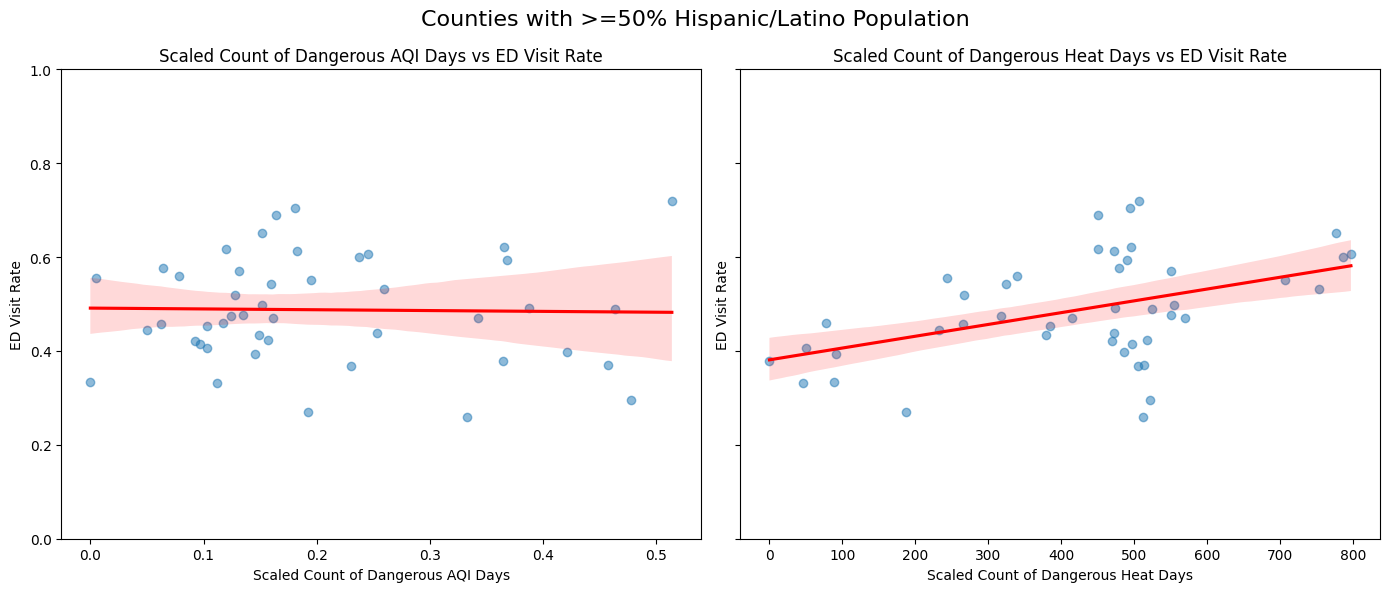

                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     6.342
Date:                Fri, 20 Dec 2024   Prob (F-statistic):            0.00392
Time:                        13:37:53   Log-Likelihood:                 40.617
No. Observations:                  45   AIC:                            -75.23
Df Residuals:                      42   BIC:                            -69.81
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3993      0.03

In [53]:
# linear regression > 50% hispanic

x_hisp = df_hospital_aqi_heat_poverty_hisp[["Weighted AQI Days", "Weighted HI Days"]]
y_hisp = df_hospital_aqi_heat_poverty_hisp["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2_hisp = sm.add_constant(x_hisp)

# Fit the simple linear regression
sm_model_hisp = sm.OLS(y_hisp, x2_hisp)
results_hisp= sm_model_hisp.fit()

# Make predictions using the linear regression
y_pred_hisp = results_hisp.predict(x2_hisp)

import seaborn as sns
import matplotlib.pyplot as plt

# Add predicted VisitRate to the DataFrame
df_hospital_aqi_heat_poverty_hisp["VisitRate_Pred"] = y_pred_hisp

# Plotting the relationship between each predictor and VisitRate
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot 1: Weighted AQI Days vs VisitRate
sns.regplot(
    ax=axes[0],
    x="Weighted AQI Days",
    y="VisitRate",
    data=df_hospital_aqi_heat_poverty_hisp,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[0].set_ylim(0, 1)
axes[0].set_title("Scaled Count of Dangerous AQI Days vs ED Visit Rate")
axes[0].set_xlabel("Scaled Count of Dangerous AQI Days")
axes[0].set_ylabel("ED Visit Rate")

# Plot 2: Weighted HI Days vs VisitRate
sns.regplot(
    ax=axes[1],
    x="Weighted HI Days",
    y="VisitRate",
    data=df_hospital_aqi_heat_poverty_hisp,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[1].set_ylim(0, 1)
axes[1].set_title("Scaled Count of Dangerous Heat Days vs ED Visit Rate")
axes[1].set_xlabel("Scaled Count of Dangerous Heat Days")
axes[1].set_ylabel("ED Visit Rate")

fig.suptitle("Counties with >=50% Hispanic/Latino Population", fontsize=16)

# Adjust layout and display the plots
print("HISPANIC MAJORITY COUNTIES")
plt.tight_layout()
plt.show()

print(results_hisp.summary())

/var/folders/1d/gjghwm397n7cr3rpcndcs8rh0000gn/T/ipykernel_59560/553765131.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hospital_aqi_heat_poverty_not_hisp["VisitRate_Pred"] = y_pred_not_hisp


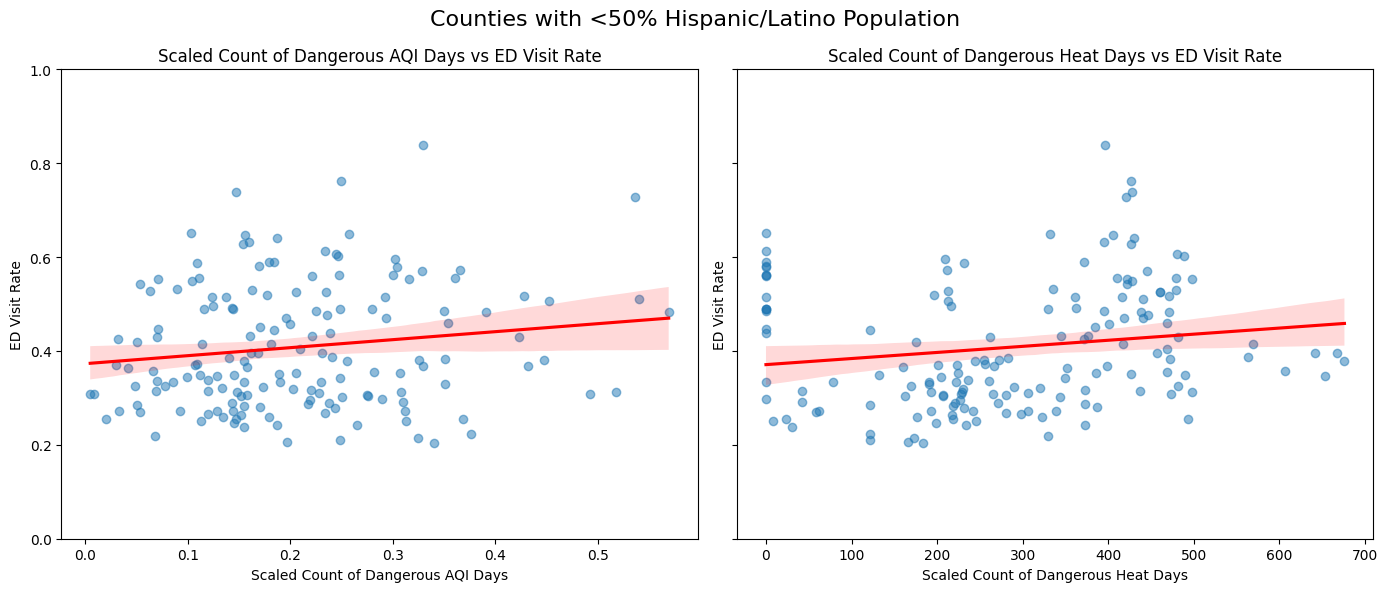

                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     3.624
Date:                Fri, 20 Dec 2024   Prob (F-statistic):             0.0289
Time:                        13:37:53   Log-Likelihood:                 101.85
No. Observations:                 160   AIC:                            -197.7
Df Residuals:                     157   BIC:                            -188.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3432      0.02

In [54]:
# linear regression < 50% hispanic

x_not_hisp = df_hospital_aqi_heat_poverty_not_hisp[["Weighted AQI Days", "Weighted HI Days"]]
y_not_hisp = df_hospital_aqi_heat_poverty_not_hisp["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2_not_hisp = sm.add_constant(x_not_hisp)

# Fit the simple linear regression
sm_model_not_hisp = sm.OLS(y_not_hisp, x2_not_hisp)
results_not_hisp= sm_model_not_hisp.fit()

# Make predictions using the linear regression
y_pred_not_hisp = results_not_hisp.predict(x2_not_hisp)

# Add predicted VisitRate to the DataFrame
df_hospital_aqi_heat_poverty_not_hisp["VisitRate_Pred"] = y_pred_not_hisp

# Plotting the relationship between each predictor and VisitRate
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot 1: Weighted AQI Days vs VisitRate
sns.regplot(
    ax=axes[0],
    x="Weighted AQI Days",
    y="VisitRate",
    data=df_hospital_aqi_heat_poverty_not_hisp,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[0].set_ylim(0, 1)
axes[0].set_title("Scaled Count of Dangerous AQI Days vs ED Visit Rate")
axes[0].set_xlabel("Scaled Count of Dangerous AQI Days")
axes[0].set_ylabel("ED Visit Rate")

# Plot 2: WarningHeatDays vs VisitRate
sns.regplot(
    ax=axes[1],
    x="Weighted HI Days",
    y="VisitRate",
    data=df_hospital_aqi_heat_poverty_not_hisp,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[1].set_ylim(0, 1)
axes[1].set_title("Scaled Count of Dangerous Heat Days vs ED Visit Rate")
axes[1].set_xlabel("Scaled Count of Dangerous Heat Days")
axes[1].set_ylabel("ED Visit Rate")

fig.suptitle("Counties with <50% Hispanic/Latino Population", fontsize=16)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

print(results_not_hisp.summary())

In [55]:
# Perform SIMPLE linear regression (now that we're not considering AQI) 

# df_hospital_aqi_heat_poverty_not_hisp_filtered = df_hospital_aqi_heat_poverty_not_hisp[df_hospital_aqi_heat_poverty_not_hisp["Weighted HI Days"] > 100]
# df_hospital_aqi_heat_poverty_hisp_filtered = df_hospital_aqi_heat_poverty_hisp[df_hospital_aqi_heat_poverty_hisp["Weighted HI Days"] > 100]

# x_not_hisp = df_hospital_aqi_heat_poverty_not_hisp_filtered["Weighted HI Days"]
# y_not_hisp = df_hospital_aqi_heat_poverty_not_hisp_filtered["VisitRate"]

x_not_hisp = df_hospital_aqi_heat_poverty_not_hisp["Weighted HI Days"]
y_not_hisp = df_hospital_aqi_heat_poverty_not_hisp["VisitRate"]

x2_not_hisp = sm.add_constant(x_not_hisp)

sm_model_not_hisp = sm.OLS(y_not_hisp, x2_not_hisp)
results_not_hisp = sm_model_not_hisp.fit()


x_hisp = df_hospital_aqi_heat_poverty_hisp["Weighted HI Days"]
y_hisp = df_hospital_aqi_heat_poverty_hisp["VisitRate"]

x2_hisp = sm.add_constant(x_hisp)

sm_model_hisp = sm.OLS(y_hisp, x2_hisp)
results_hisp = sm_model_hisp.fit()


In [56]:
results_hisp.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.179   
Dependent Variable: VisitRate        AIC:                -75.2433
Date:               2024-12-20 13:37 BIC:                -71.6300
No. Observations:   45               Log-Likelihood:     39.622  
Df Model:           1                F-statistic:        10.56   
Df Residuals:       43               Prob (F-statistic): 0.00224 
R-squared:          0.197            Scale:              0.010532
-----------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|  [0.025 0.975]
-----------------------------------------------------------------
const                0.3811   0.0362 10.5275 0.0000 0.3081 0.4541
Weighted HI Days     0.0003   0.0001  3.2501 0.0022 0.0001 0.0004
-----------------------------------------------------------------
Omnibus:               0.390        Durbin-Watson:          0.880
Prob(Omnibus):         0.823        Jarque-Bera (JB):       0.098
Skew:                  -0.111       Prob(JB):               0.952
Kurtosis:              3.054        Condition No.:          1107 
=================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
[2] The condition number is large, 1.11e+03. This might indicate
that there are strong multicollinearity or other numerical
problems.
"""

In [57]:
results_not_hisp.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.021    
Dependent Variable: VisitRate        AIC:                -196.8670
Date:               2024-12-20 13:37 BIC:                -190.7166
No. Observations:   160              Log-Likelihood:     100.43   
Df Model:           1                F-statistic:        4.391    
Df Residuals:       158              Prob (F-statistic): 0.0377   
R-squared:          0.027            Scale:              0.016895 
-------------------------------------------------------------------
                  Coef.   Std.Err.     t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------
const             0.3709    0.0205  18.0648  0.0000  0.3303  0.4115
Weighted HI Days  0.0001    0.0001   2.0954  0.0377  0.0000  0.0003
------------------------------------------------------------------
Omnibus:               12.411       Durbin-Watson:          0.582 
Prob(Omnibus):         0.002        Jarque-Bera (JB):       13.802
Skew:                  0.707        Prob(JB):               0.001 
Kurtosis:              2.739        Condition No.:          662   
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

In [58]:
from statsmodels.stats.outliers_influence import summary_table

st, data, _ = summary_table(results_hisp, alpha=0.05)

fitted_values_maj = data[:, 2]  # Predicted values
ci_low_maj = data[:, 4]         # Lower bound of CI
ci_high_maj = data[:, 5]        # Upper bound of CI

st, data, _ = summary_table(results_not_hisp, alpha=0.05)

fitted_values_min = data[:, 2]  # Predicted values
ci_low_min = data[:, 4]         # Lower bound of CI
ci_high_min = data[:, 5]        # Upper bound of CI

In [59]:
x_min = df_hospital_aqi_heat_poverty_not_hisp["Weighted HI Days"] 
x_maj = df_hospital_aqi_heat_poverty_hisp["Weighted HI Days"]

results = []
for i in range(len(x_min)):
    if ci_low_maj[i] > ci_high_min[i]:
        results.append({
            "x": x_min.iloc[i],
            "ci_low_maj": ci_low_maj[i],
            "ci_high_maj": ci_high_maj[i],
            "ci_low_min": ci_low_min[i],
            "ci_high_min": ci_high_min[i]
        })
        break

results_df = pd.DataFrame(results)

print(results_df)

lower_ci_overlap = results_df.loc[0, 'x']
lower_ci_overlap


       x  ci_low_maj  ci_high_maj  ci_low_min  ci_high_min
0  361.0    0.476056     0.543572    0.395532     0.439982


361.0

In [60]:
# x_min = df_hospital_aqi_heat_poverty_not_hisp["Weighted HI Days"]  
# x_maj = df_hospital_aqi_heat_poverty_hisp["Weighted HI Days"]

# Filtering x > 500
mask_maj = x_maj > 500 # from looking at the plot 
mask_min = x_min > 500
x_filtered_min = x_min[mask_min]

# Extract the filtered confidence intervals and predictions for the two groups
ci_low_maj_filtered = ci_low_maj[mask_maj]
ci_high_maj_filtered = ci_high_maj[mask_maj]
ci_low_min_filtered = ci_low_min[mask_min]
ci_high_min_filtered = ci_high_min[mask_min]

# Loop through filtered x and check the condition
results = []
for i in range(len(x_filtered_min)):
    if ci_low_maj_filtered[i] < ci_high_min_filtered[i]:
        results.append({
            "x": x_filtered_min.iloc[i],
            "ci_low_maj": ci_low_maj_filtered[i],
            "ci_high_maj": ci_high_maj_filtered[i],
            "ci_low_min": ci_low_min_filtered[i],
            "ci_high_min": ci_high_min_filtered[i]
        })


# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results)

print(results_df)

upper_ci_overlap = value = results_df.loc[1, 'x']
upper_ci_overlap

       x  ci_low_maj  ci_high_maj  ci_low_min  ci_high_min
0  569.0    0.476056     0.543572    0.404724     0.484784
1  563.0    0.478451     0.547713    0.404576     0.483375


563.0

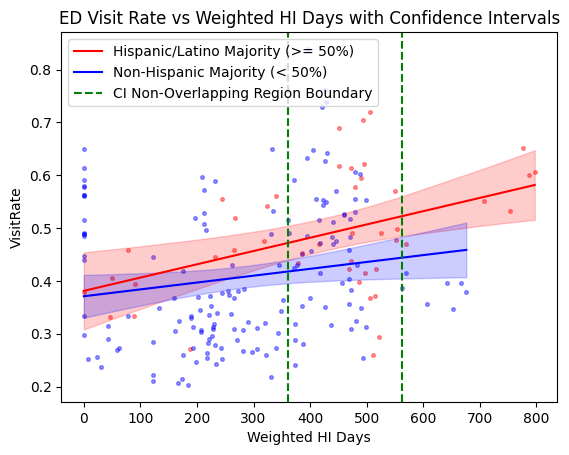

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the Hispanic/Latino majority data by x-axis
sorted_indices_maj = np.argsort(x_maj)
x_maj_sorted = np.array(x_maj)[sorted_indices_maj]
fitted_values_maj_sorted = np.array(fitted_values_maj)[sorted_indices_maj]
ci_low_maj_sorted = np.array(ci_low_maj)[sorted_indices_maj]
ci_high_maj_sorted = np.array(ci_high_maj)[sorted_indices_maj]

# Sort the Non-Hispanic majority data by x-axis
sorted_indices_min = np.argsort(x_min)
x_min_sorted = np.array(x_min)[sorted_indices_min]
fitted_values_min_sorted = np.array(fitted_values_min)[sorted_indices_min]
ci_low_min_sorted = np.array(ci_low_min)[sorted_indices_min]
ci_high_min_sorted = np.array(ci_high_min)[sorted_indices_min]

# Plot the data points
plt.scatter(
    df_hospital_aqi_heat_poverty_hisp["Weighted HI Days"], 
    df_hospital_aqi_heat_poverty_hisp["VisitRate"], 
    alpha=0.4, color="red", s=7
)
plt.scatter(
    df_hospital_aqi_heat_poverty_not_hisp["Weighted HI Days"], 
    df_hospital_aqi_heat_poverty_not_hisp["VisitRate"], 
    alpha=0.4, color="blue", s=7
)

# Plot the regression lines
plt.plot(x_maj_sorted, fitted_values_maj_sorted, color="red", label="Hispanic/Latino Majority (>= 50%)")
plt.plot(x_min_sorted, fitted_values_min_sorted, color="blue", label="Non-Hispanic Majority (< 50%)")

# Fill between for confidence intervals
plt.fill_between(
    x_maj_sorted, ci_low_maj_sorted, ci_high_maj_sorted, color="red", alpha=0.2
)
plt.fill_between(
    x_min_sorted, ci_low_min_sorted, ci_high_min_sorted, color="blue", alpha=0.2
)

plt.axvline(x=upper_ci_overlap, color='green', linestyle='--', label='CI Non-Overlapping Region Boundary')
plt.axvline(x=lower_ci_overlap, color='green', linestyle='--')

# Add labels and legend
plt.xlabel("Weighted HI Days")
plt.ylabel("VisitRate")
plt.title("ED Visit Rate vs Weighted HI Days with Confidence Intervals")
plt.legend()
plt.show()


Hispanic Majority Predictions:
       mean  mean_ci_lower  mean_ci_upper
0  0.381099       0.308094       0.454104
1  0.381101       0.308097       0.454105
2  0.381103       0.308100       0.454106
3  0.381105       0.308103       0.454107
4  0.381107       0.308106       0.454107

Hispanic Minority Predictions:
       mean  mean_ci_lower  mean_ci_upper
0  0.370902       0.330350       0.411454
1  0.370903       0.330352       0.411454
2  0.370904       0.330354       0.411455
3  0.370905       0.330355       0.411455
4  0.370906       0.330357       0.411455
overlap stop: 365.4361243612436
overlap restart: 583.0671206712068


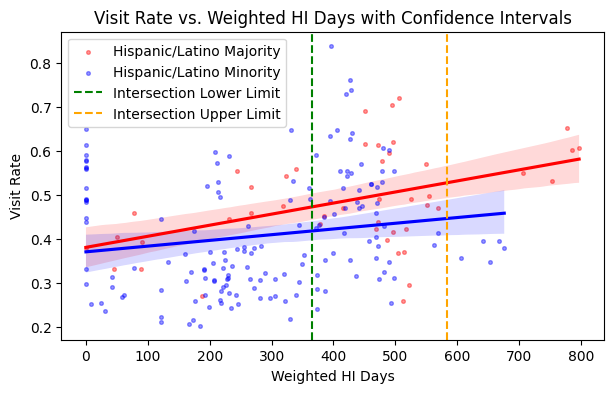

In [62]:
## This one is not correct because it uses a different bootstrapped data set than 
# the green and orange lines, since sns.regplot does the linear regression internally

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import pandas as pd

# Create a plot with a larger figure
plt.figure(figsize=(7, 4))
np.random.seed(40) # Seed forces same bootstrapping for confidence interval

# Plot the first regression line (Hispanic/Latino Majority)
sns.regplot(
    x="Weighted HI Days",
    y="VisitRate",
    data=df_hospital_aqi_heat_poverty_hisp,
    scatter_kws={"alpha": 0.4, "color": "red", 's':7},
    line_kws={"color": "red"},
    label="Hispanic/Latino Majority",
    ci=95  # Confidence interval, you can adjust as needed
)

# Plot the second regression line (Hispanic/Latino Minority)
sns.regplot(
    x="Weighted HI Days",
    y="VisitRate",
    data=df_hospital_aqi_heat_poverty_not_hisp,
    scatter_kws={"alpha": 0.4, "color": "blue", 's':7},
    line_kws={"color": "blue"},
    label="Hispanic/Latino Minority",
    ci=95  # Confidence interval, you can adjust as needed
)

def get_conf_intervals_at_values(model, df, x_column, y_column, values, predictions):
    # Adding a constant for the intercept term
    X = sm.add_constant(df[x_column])
    y = df[y_column]
    
    model = sm.OLS(y, X).fit()

    # Get predictions and confidence intervals
    predictions = model.get_prediction(sm.add_constant(values)).summary_frame(alpha=0.05)  # 95% CI
    return predictions[['mean', 'mean_ci_lower', 'mean_ci_upper']]

# Prepare a range of values for "Weighted HI Days" to check
# Assuming you want to check the range between the min and max values in the dataset
hi_values = np.linspace(df_hospital_aqi_heat_poverty_hisp['Weighted HI Days'].min(),
                              df_hospital_aqi_heat_poverty_hisp['Weighted HI Days'].max(), 100000)

# Get the predicted values and confidence intervals for Hispanic Majority
pred_hispanic = get_conf_intervals_at_values(results_hisp, df_hospital_aqi_heat_poverty_hisp, 'Weighted HI Days', 'VisitRate', hi_values, y_pred_hisp)

# Similarly, for Hispanic Minority
pred_minority = get_conf_intervals_at_values(results_not_hisp, df_hospital_aqi_heat_poverty_not_hisp, 'Weighted HI Days', 'VisitRate', hi_values, y_pred_not_hisp)

# Print out the first few rows of both predictions (mean, lower CI, upper CI)
print("Hispanic Majority Predictions:")
print(pred_hispanic.head())
print("\nHispanic Minority Predictions:")
print(pred_minority.head())


#  Initialize variables for tracking overlap regions
overlap_stop = None
overlap_restart = None

for i, x in enumerate(hi_values):
    # Check for non-overlap condition
    if pred_hispanic['mean_ci_lower'][i] > pred_minority['mean_ci_upper'][i]:
        if overlap_stop is None:  # First instance of non-overlap
            overlap_stop = x
            # print("overlap stop:", overlap_stop)
            # print(overlap_restart)
    elif overlap_stop is not None and overlap_restart is None:
        # Check for resumption of overlap
        if pred_hispanic['mean_ci_lower'][i] <= pred_minority['mean_ci_upper'][i]:
            overlap_restart = x
            break
print("overlap stop:", overlap_stop)
print("overlap restart:", overlap_restart)

# Plot vertical lines where these limits intersect
plt.axvline(x=overlap_stop, color='green', linestyle='--', label='Intersection Lower Limit')
plt.axvline(x=overlap_restart, color='orange', linestyle='--', label='Intersection Upper Limit')

# Add labels and legend
plt.title("Visit Rate vs. Weighted HI Days with Confidence Intervals")
plt.xlabel("Weighted HI Days")
plt.ylabel("Visit Rate")
plt.legend()

# Show the plot
plt.show()


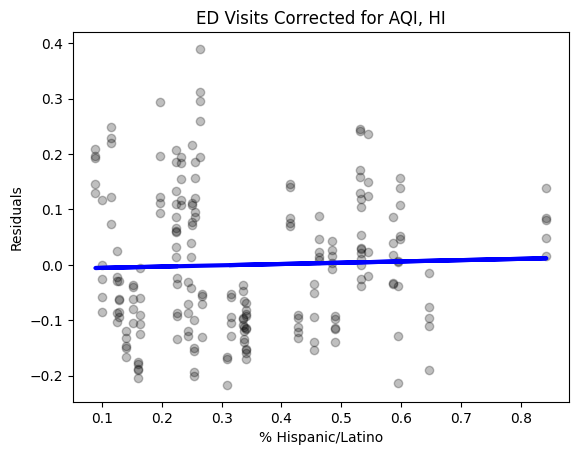

In [63]:
# Plot linear regression of % hispanic against residuals from total data plot

# df_ethnicity['% Hispanic/Latino']
correcting_df = pd.merge(df_ethnicity, resids_df, on='CountyName')

x = correcting_df["% Hispanic/Latino"]
y = correcting_df['residuals']

# In order to have an intercept, we need to add a column of 1's to X
x2 = sm.add_constant(x)

# Fit the simple linear regression
sm_model = sm.OLS(y, x2)
results = sm_model.fit()

# Make predictions using the linear regression
y_pred = results.predict(x2)

# Plot 
plt.scatter(x, y,  color='black', alpha = 0.25)
plt.plot(x, y_pred, color='blue', linewidth=3)
plt.xlabel('% Hispanic/Latino')
plt.ylabel('Residuals')
plt.title("ED Visits Corrected for AQI, HI")
plt.show()

In [64]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.2207
Date:                Fri, 20 Dec 2024   Prob (F-statistic):              0.639
Time:                        13:37:54   Log-Likelihood:                 134.60
No. Observations:                 205   AIC:                            -265.2
Df Residuals:                     203   BIC:                            -258.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0079      0.01

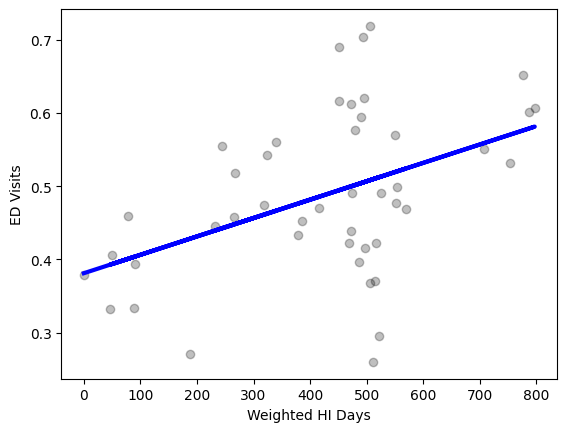

In [65]:
# linear regression just on HI df_hospital_aqi_heat_poverty_hisp
x = df_hospital_aqi_heat_poverty_hisp["Weighted HI Days"]
y = df_hospital_aqi_heat_poverty_hisp['VisitRate']

# In order to have an intercept, we need to add a column of 1's to X
x2 = sm.add_constant(x)

# Fit the simple linear regression
sm_model = sm.OLS(y, x2)
results = sm_model.fit()

# Make predictions using the linear regression
y_pred = results.predict(x2)

# Plot 
plt.scatter(x, y,  color='black', alpha = 0.25)
plt.plot(x, y_pred, color='blue', linewidth=3)
plt.xlabel('Weighted HI Days')
plt.ylabel('ED Visits')
plt.show()

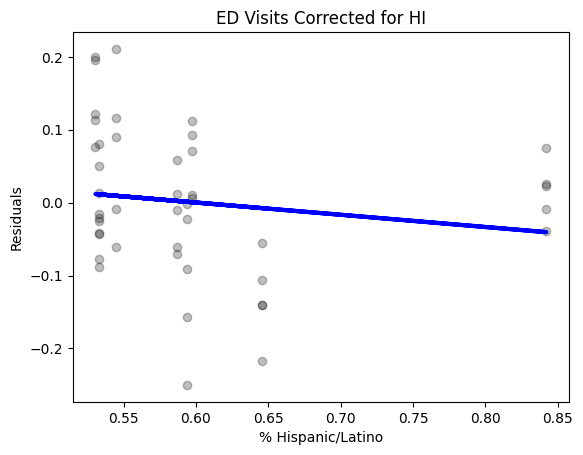

In [66]:
# df_ethnicity['% Hispanic/Latino']
d = {'residuals':results.resid, 'CountyName':df_hospital_aqi_heat_poverty_hisp['CountyName']}
resids_df = pd.DataFrame(data = d)
correcting_df = pd.merge(df_ethnicity, resids_df, on='CountyName')

x = correcting_df["% Hispanic/Latino"]
y = correcting_df['residuals']

# In order to have an intercept, we need to add a column of 1's to X
x2 = sm.add_constant(x)

# Fit the simple linear regression
sm_model = sm.OLS(y, x2)
results = sm_model.fit()

# Make predictions using the linear regression
y_pred = results.predict(x2)

# Plot 
plt.scatter(x, y,  color='black', alpha = 0.25)
plt.plot(x, y_pred, color='blue', linewidth=3)
plt.xlabel('% Hispanic/Latino')
plt.ylabel('Residuals')
plt.title("ED Visits Corrected for HI")
plt.show()

In [67]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.063
Date:                Fri, 20 Dec 2024   Prob (F-statistic):              0.308
Time:                        13:37:54   Log-Likelihood:                 40.171
No. Observations:                  45   AIC:                            -76.34
Df Residuals:                      43   BIC:                            -72.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1008      0.09

## Get insurance data

In [68]:
df_insurance = pd.read_csv('Health_Insurance_Coverage_-_by_County.csv', encoding = "ISO-8859-1")
df_insurance = df_insurance[["GEO_NAME", "Percent of Population with No Health Insurance Coverage"]]
df_insurance = df_insurance.rename(columns={"GEO_NAME" : "CountyName"})
df_insurance["CountyName"] = df_insurance["CountyName"].str.replace(" County", "", regex=False)
df_insurance["Lacking Insurance"] = df_insurance["Percent of Population with No Health Insurance Coverage"] > 7.5
df_insurance["Lacking Insurance"] = df_insurance["Lacking Insurance"].astype(int)

df_hospital_aqi_heat_poverty_ethn_insurance = pd.merge(df_hospital_aqi_heat_poverty_ethn, df_insurance[["CountyName", "Lacking Insurance"]], on=["CountyName"], how='inner')
df_less_insurance = df_hospital_aqi_heat_poverty_ethn_insurance[df_hospital_aqi_heat_poverty_ethn_insurance["Lacking Insurance"] == 1]
df_more_insurance = df_hospital_aqi_heat_poverty_ethn_insurance[df_hospital_aqi_heat_poverty_ethn_insurance["Lacking Insurance"] == 0]


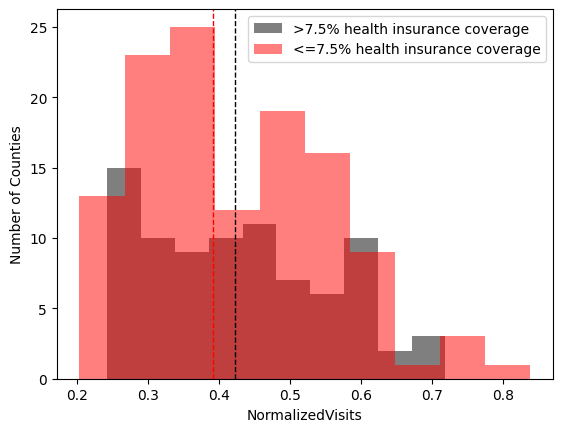

The p-value for the Moods Median test is  0.45806206012762685
The grand median (median for all both samples together) is  0.414455626715462
The contingency table is: 
 [[44 57]
 [39 65]]
There is NOT a statistically significant difference between the two insurance groups


In [69]:
plt.hist(df_less_insurance['VisitRate'], 
         alpha=0.5, 
         color='black',
         label='>7.5% health insurance coverage')
  
plt.hist(df_more_insurance['VisitRate'],
         alpha=0.5,
         color = 'red',
         label='<=7.5% health insurance coverage')

plt.axvline(df_less_insurance['VisitRate'].median(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(df_more_insurance['VisitRate'].median(), color='red', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('NormalizedVisits')
plt.ylabel('Number of Counties')
plt.show()


stat, p, med, tbl = median_test(df_less_insurance['VisitRate'], df_more_insurance['VisitRate'])
print('The p-value for the Moods Median test is ', p)
print('The grand median (median for all both samples together) is ', med)
print('The contingency table is: \n', tbl)
("For ED Visit Rate:")
if (p < 0.01):
        print("There IS a statistically significant difference between the two insurance groups")
else: 
        print("There is NOT a statistically significant difference between the two insurance groups")

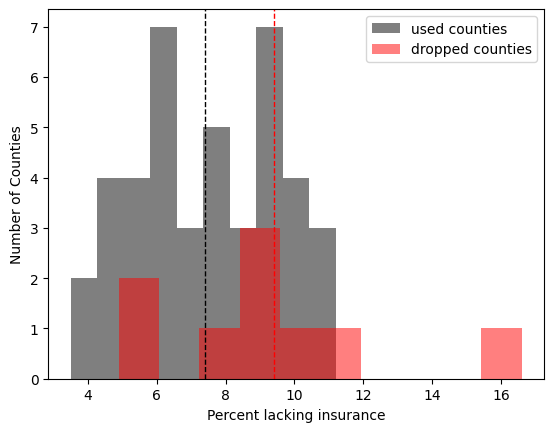

The p-value for the Moods Median test is  0.09559221885853068
The grand median (median for all both samples together) is  7.5
The contingency table is: 
 [[17  7]
 [25  2]]
There is NOT a statistically significant difference between the included and excluded counties


In [70]:
# Code for testing differnce between included/excluded counties
# Split insurance data by 'used' and 'dropped' counties
used_counties = df_insurance[df_insurance['CountyName'].isin(used_county_list)]
dropped_counties = df_insurance[df_insurance['CountyName'].isin(dropped_county_list)] 


# Moods median 
plt.hist(used_counties['Percent of Population with No Health Insurance Coverage'], 
         alpha=0.5, 
         color='black',
         label='used counties')
  
plt.hist(dropped_counties['Percent of Population with No Health Insurance Coverage'],
         alpha=0.5,
         color = 'red',
         label='dropped counties')

plt.axvline(used_counties['Percent of Population with No Health Insurance Coverage'].median(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(dropped_counties['Percent of Population with No Health Insurance Coverage'].median(), color='red', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('Percent lacking insurance')
plt.ylabel('Number of Counties')
plt.show()


stat, p, med, tbl = median_test(used_counties['Percent of Population with No Health Insurance Coverage'], dropped_counties['Percent of Population with No Health Insurance Coverage'])
print('The p-value for the Moods Median test is ', p)
print('The grand median (median for all both samples together) is ', med)
print('The contingency table is: \n', tbl)
("For percent insurance coverage:")
if (p < 0.01):
        print("There IS a statistically significant difference between the included and excluded counties")
else: 
        print("There is NOT a statistically significant difference between the included and excluded counties")

>7.5% LACKING INSURANCE


/var/folders/1d/gjghwm397n7cr3rpcndcs8rh0000gn/T/ipykernel_59560/2672680607.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_less_insurance["VisitRate_Pred"] = y_pred_less_insurance


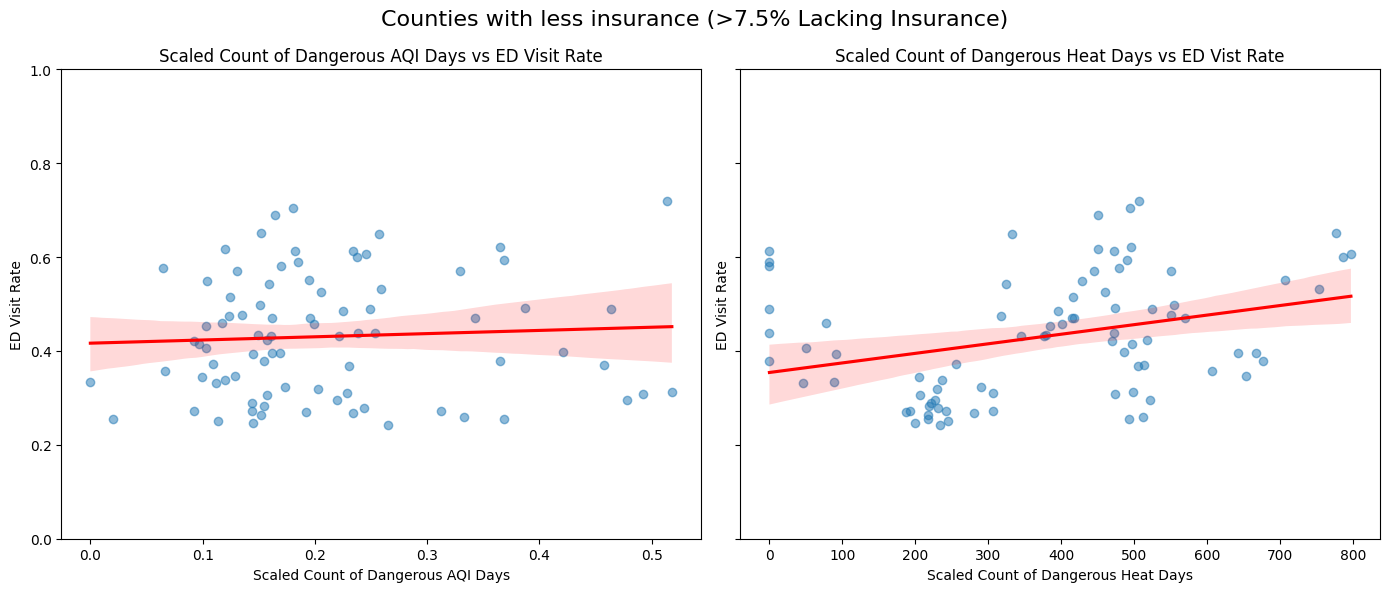

                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     4.582
Date:                Fri, 20 Dec 2024   Prob (F-statistic):             0.0131
Time:                        13:37:54   Log-Likelihood:                 57.524
No. Observations:                  83   AIC:                            -109.0
Df Residuals:                      80   BIC:                            -101.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3567      0.03

In [71]:
# linear regression > 7.5% lacking insurance

x_less_insurance = df_less_insurance[["Weighted AQI Days", "Weighted HI Days"]]
y_less_insurance = df_less_insurance["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2_less_insurance = sm.add_constant(x_less_insurance)

# Fit the simple linear regression
sm_model_less_insurance = sm.OLS(y_less_insurance, x2_less_insurance)
results_less_insurance = sm_model_less_insurance.fit()

# Make predictions using the linear regression
y_pred_less_insurance = results_less_insurance.predict(x2_less_insurance)

# Add predicted VisitRate to the DataFrame
df_less_insurance["VisitRate_Pred"] = y_pred_less_insurance

# Plotting the relationship between each predictor and VisitRate
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot 1: Weighted AQI Days vs VisitRate
sns.regplot(
    ax=axes[0],
    x="Weighted AQI Days",
    y="VisitRate",
    data=df_less_insurance,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[0].set_ylim(0, 1)
axes[0].set_title("Scaled Count of Dangerous AQI Days vs ED Visit Rate")
axes[0].set_xlabel("Scaled Count of Dangerous AQI Days")
axes[0].set_ylabel("ED Visit Rate")

# Plot 2: WarningHeatDays vs VisitRate
sns.regplot(
    ax=axes[1],
    x="Weighted HI Days",
    y="VisitRate",
    data=df_less_insurance,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[1].set_ylim(0, 1)
axes[1].set_title("Scaled Count of Dangerous Heat Days vs ED Vist Rate")
axes[1].set_xlabel("Scaled Count of Dangerous Heat Days")
axes[1].set_ylabel("ED Visit Rate")

fig.suptitle("Counties with less insurance (>7.5% Lacking Insurance)", fontsize=16)

# Adjust layout and display the plots
print(">7.5% LACKING INSURANCE")
plt.tight_layout()
plt.show()

print(results_less_insurance.summary())

/var/folders/1d/gjghwm397n7cr3rpcndcs8rh0000gn/T/ipykernel_59560/3575674364.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_more_insurance["VisitRate_Pred"] = y_pred_more_insurance


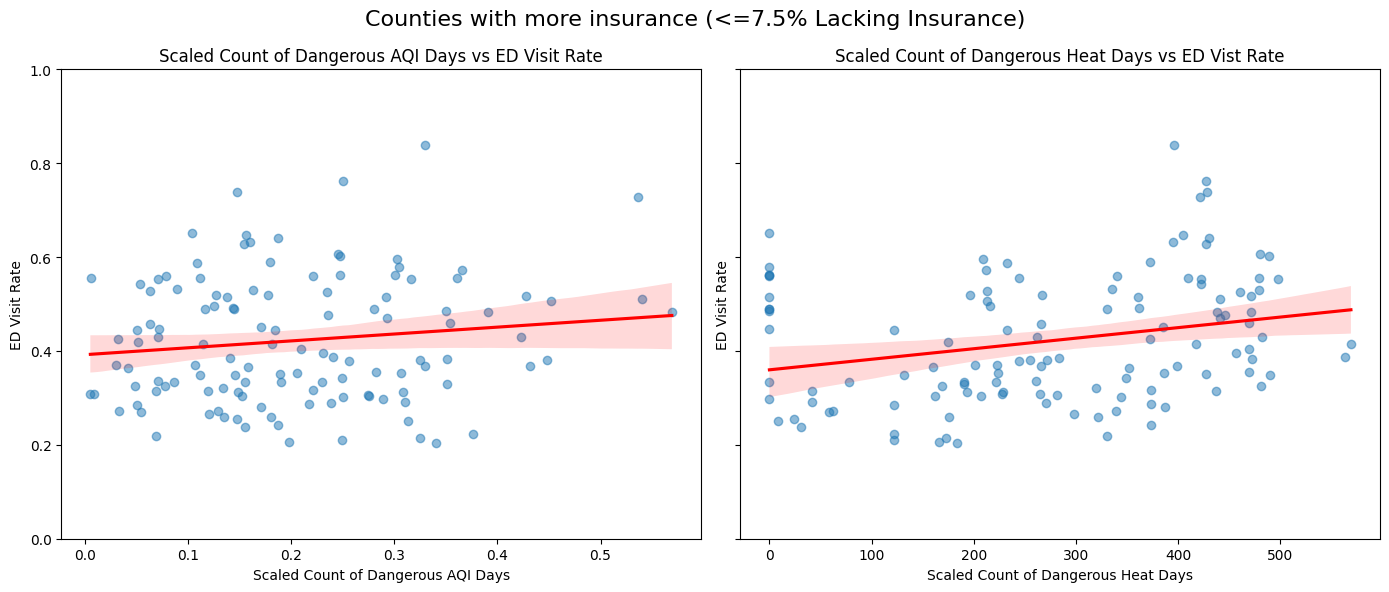

                            OLS Regression Results                            
Dep. Variable:              VisitRate   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     5.167
Date:                Fri, 20 Dec 2024   Prob (F-statistic):            0.00705
Time:                        13:37:55   Log-Likelihood:                 77.698
No. Observations:                 122   AIC:                            -149.4
Df Residuals:                     119   BIC:                            -141.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3399      0.02

In [72]:
# linear regression < 7.5% lacking insurance

x_more_insurance = df_more_insurance[["Weighted AQI Days", "Weighted HI Days"]]
y_more_insurance = df_more_insurance["VisitRate"]

# In order to have an intercept, we need to add a column of 1's to X
x2_more_insurance = sm.add_constant(x_more_insurance)

# Fit the simple linear regression
sm_model_more_insurance = sm.OLS(y_more_insurance, x2_more_insurance)
results_more_insurance = sm_model_more_insurance.fit()

# Make predictions using the linear regression
y_pred_more_insurance = results_more_insurance.predict(x2_more_insurance)

# Add predicted VisitRate to the DataFrame
df_more_insurance["VisitRate_Pred"] = y_pred_more_insurance

# Plotting the relationship between each predictor and VisitRate
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot 1: Weighted AQI Days vs VisitRate
sns.regplot(
    ax=axes[0],
    x="Weighted AQI Days",
    y="VisitRate",
    data=df_more_insurance,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[0].set_ylim(0, 1)
axes[0].set_title("Scaled Count of Dangerous AQI Days vs ED Visit Rate")
axes[0].set_xlabel("Scaled Count of Dangerous AQI Days")
axes[0].set_ylabel("ED Visit Rate")

# Plot 2: WarningHeatDays vs VisitRate
sns.regplot(
    ax=axes[1],
    x="Weighted HI Days",
    y="VisitRate",
    data=df_more_insurance,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"}
)
axes[1].set_ylim(0, 1)
axes[1].set_title("Scaled Count of Dangerous Heat Days vs ED Vist Rate")
axes[1].set_xlabel("Scaled Count of Dangerous Heat Days")
axes[1].set_ylabel("ED Visit Rate")

fig.suptitle("Counties with more insurance (<=7.5% Lacking Insurance)", fontsize=16)


# Adjust layout and display the plots
plt.tight_layout()
plt.show()

print(results_more_insurance.summary())

Shapiro-Wilk Test Statistic: 0.9870421290397644
p-value: 0.8896353840827942
Residuals appear to be normally distributed (fail to reject H0).


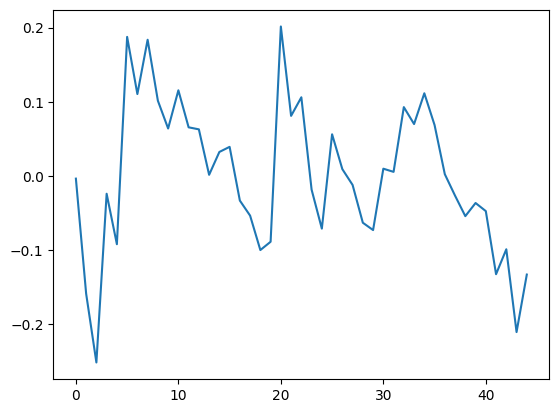

In [73]:
#Shapiro Wilks Test

residuals = y - y_pred

# Perform the Shapiro-Wilk test on residuals
from scipy.stats import shapiro
stat, p_value = shapiro(residuals)

plt.plot(residuals)

# Print the results
print("Shapiro-Wilk Test Statistic:", stat)
print("p-value:", p_value)

# Interpret the results
if p_value > 0.05:
    print("Residuals appear to be normally distributed (fail to reject H0).")
else:
    print("Residuals do not appear to be normally distributed (reject H0).")

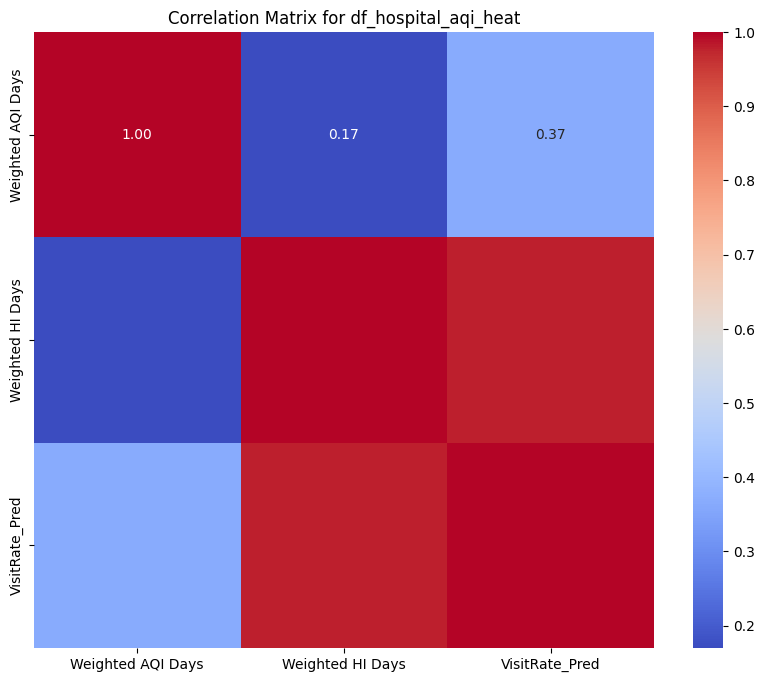

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = df_hospital_aqi_heat.drop(["VisitRate"], axis=1).corr()

# Display the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix for df_hospital_aqi_heat")
plt.show()

In [75]:
# make daily aqi df function
def make_aqi_daily(csv_name):
    df_daily = pd.read_csv(csv_name)
    df_daily['Date'] = pd.to_datetime(df_daily['Date'])
    df_daily['CountyName'] = df_daily['County']
    return df_daily[['CountyName','Date','Daily AQI Value']]
# Make daily AQI dataframes for each year
df_aqi_daily_2015 = make_aqi_daily('air_quality_2015.csv')
df_aqi_daily_2016 = make_aqi_daily('air_quality_2016.csv')
df_aqi_daily_2017 = make_aqi_daily('air_quality_2017.csv')
df_aqi_daily_2018 = make_aqi_daily('air_quality_2018.csv')
df_aqi_daily_2019 = make_aqi_daily('air_quality_2019.csv')
# Combine all years into one dataframe
df_aqi_daily_all = pd.concat([df_aqi_daily_2015, df_aqi_daily_2016, df_aqi_daily_2017, df_aqi_daily_2018, df_aqi_daily_2019], axis=0)
df_aqi_daily_all.head

# drop unique counties for aqi dataframe
unique_counties_aqi = ['Calaveras', 'Glenn','Lake','Madera','Mariposa','Trinity','Nevada','Merced','Mono']
index_names = df_aqi_daily_all[ df_aqi_daily_all['CountyName'] == any(unique_counties_aqi)].index 
  
# drop these row indexes 
# from dataFrame 
df_aqi_daily_all.drop(df_aqi_daily_all[ df_aqi_daily_all['CountyName'] == 'Calaveras'].index, inplace = True) 
df_aqi_daily_all.drop(df_aqi_daily_all[ df_aqi_daily_all['CountyName'] == 'Glenn'].index, inplace = True) 
df_aqi_daily_all.drop(df_aqi_daily_all[ df_aqi_daily_all['CountyName'] == 'Lake'].index, inplace = True) 
df_aqi_daily_all.drop(df_aqi_daily_all[ df_aqi_daily_all['CountyName'] == 'Madera'].index, inplace = True) 
df_aqi_daily_all.drop(df_aqi_daily_all[ df_aqi_daily_all['CountyName'] == 'Mariposa'].index, inplace = True) 
df_aqi_daily_all.drop(df_aqi_daily_all[ df_aqi_daily_all['CountyName'] == 'Trinity'].index, inplace = True) 
df_aqi_daily_all.drop(df_aqi_daily_all[ df_aqi_daily_all['CountyName'] == 'Nevada'].index, inplace = True) 
df_aqi_daily_all.drop(df_aqi_daily_all[ df_aqi_daily_all['CountyName'] == 'Merced'].index, inplace = True) 
df_aqi_daily_all.drop(df_aqi_daily_all[ df_aqi_daily_all['CountyName'] == 'Mono'].index, inplace = True) 
print("length of aqi df:",len(df_aqi_daily_all))

df_meteor.drop(df_meteor[ df_meteor['CountyName'] == 'Modoc' ].index , inplace = True) 
df_meteor.drop(df_meteor[ df_meteor['CountyName'] == 'Amador' ].index , inplace = True) 
print('length of heat df:',len(df_meteor))



length of aqi df: 204238
length of heat df: 73467


In [76]:
from statsmodels.stats.diagnostic import het_breuschpagan

# insurance
bp_test = het_breuschpagan(results_more_insurance.resid, x2_more_insurance)
# bp_test_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
# for name, value in zip(bp_test_labels, bp_test):
#     print(f"{name}: {value}")
if bp_test[1] > 0.05: 
    print("homoskedasticity present for MORE INSURANCE")
else: 
    print("heteroskedasticity present for MORE INSURANCE")

bp_test = het_breuschpagan(results_less_insurance.resid, x2_less_insurance)
if bp_test[1] > 0.01: 
    print("homoskedasticity present for LESS INSURANCE")
else: 
    print("heteroskedasticity present for LESS INSURANCE")
    bp_test_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
    for name, value in zip(bp_test_labels, bp_test):
        print(f"{name}: {value}")

# ethnicity
bp_test = het_breuschpagan(results_not_hisp.resid, x2_not_hisp)
if bp_test[1] > 0.05: 
    print("homoskedasticity present for NOT HISPANIC")
else: 
    print("heteroskedasticity present for NOT HISPANIC")

bp_test = het_breuschpagan(results_hisp.resid, x2_hisp)
if bp_test[1] > 0.05: 
    print("homoskedasticity present for HISPANIC")
else: 
    print("heteroskedasticity present for HISPANIC")

# poverty
bp_test = het_breuschpagan(results_no_pov.resid, x2_no_pov)
if bp_test[1] > 0.01: 
    print("homoskedasticity present for NO POV")
else: 
    print("heteroskedasticity present for NO POV")
    bp_test_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
    for name, value in zip(bp_test_labels, bp_test):
        print(f"{name}: {value}")


bp_test = het_breuschpagan(results_pov.resid, x2_pov)
if bp_test[1] > 0.05: 
    print("homoskedasticity present for POV")
else: 
    print("heteroskedasticity present for POV")

homoskedasticity present for MORE INSURANCE
homoskedasticity present for LESS INSURANCE
homoskedasticity present for NOT HISPANIC
homoskedasticity present for HISPANIC
homoskedasticity present for NO POV
homoskedasticity present for POV


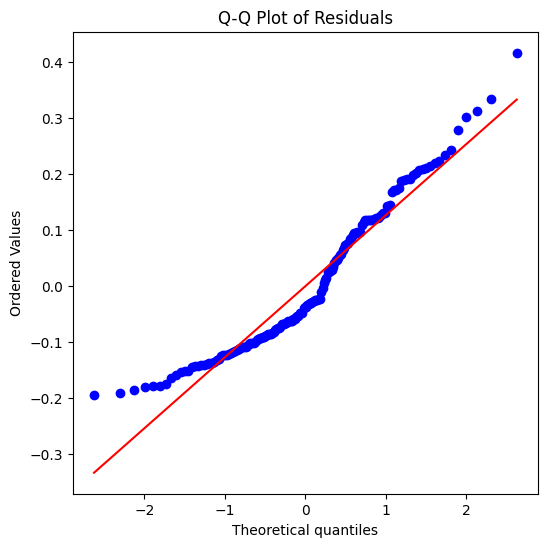

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Calculate the residuals for the model
residuals_not_hisp = results_not_hisp.resid

# Create a Q-Q plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals_not_hisp, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# this looks sufficiently normal for our comparison since we're not doing inference

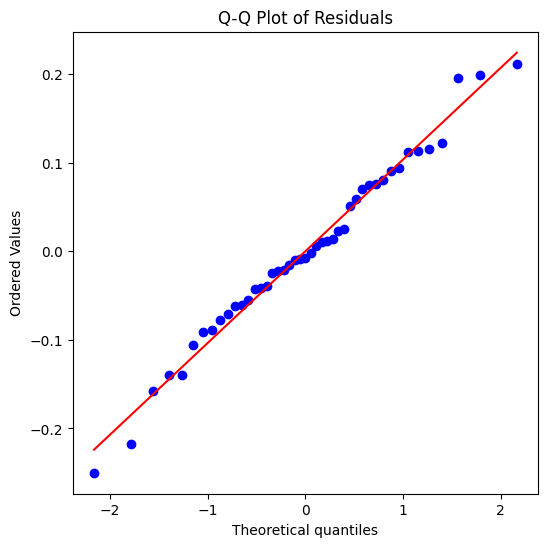

In [78]:
# Calculate the residuals for the model
residuals_hisp = results_hisp.resid

# Create a Q-Q plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals_hisp, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()